Hi all, I’m visiting some family now and played a couple of relatives in ping-pong. I couldn’t help but think of statistical models :-). For example, when playing my 8-year-old nephew, we tried to see how long rallies would last. This is his first time playing so the number of successful hits over the net were low, in the range of 2 to 4. Sometimes the counts would get as high as 15 or 20.  Since counts are mostly low but the theoretical maximum is infinity, I thought a Poisson GLM regression would apply to model successful hits. I could then extend this model by determining the difference between the average number of hits between playing my nephew versus his father (when rallies would go longer). What I’m unsure about is whether Poisson regression is the right model here because one of the assumptions for this model is that an event is “rare”. Examples in Chapter 11 of the McElreath text include counting caught fish, producing a manuscript in a monastery, and producing a tool from an island society. A successful ping-pong hit with my nephew has low counts, but is it rare? Am I over-interpreting or mis-interpreting the Poisson regression assumptions or is there really a better model?

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
from scipy.special import expit as logistic
import daft
from causalgraphicalmodels import CausalGraphicalModel

from scipy.optimize import curve_fit

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

<IPython.core.display.Javascript object>

In [3]:
sns.set_context("talk")

<IPython.core.display.Javascript object>

# Generating data of successful hits

Initially I thought I could model this by simply drawing from a Poisson distribution.

It's interesting that the alpha is coming from 

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{P[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 2) $$    


In [ ]:
ax = az.plot_kde(pm.Lognormal.dist(3.0, 0.5).random(size=20_000), label="a ~ LogNormal(3, 0.5)")
ax.set_xlabel("mean number of tools")
ax.set_ylabel("Density")
ax.set_title("");

Discourse feedback

Jan Christian Refsgaard — Today at 9:02 AM
There are two processes, you hitting it and your nephew hitting it, intuitively you both have a hit probability resulting in two different distribution depending on who goes first, i think  the data generating process for each of you should follow a geometric distributions, the distribution is probably over dispersed as your nephew will deliver shots of varying quality, but that is probably neglable, it may need a Bernoulli distribution for the serve as that may be easier or harder than the other ahots
Also i think poison would somewhat work, there are isomorphism between all the single parameter count distributions


Maximum Limelihood Estimator — Today at 10:55 AM
Also, yes, I would try a geometric distribution like Jan said. Theoretically, your nephew should have an x% chance of hitting the ball each time, so the total number of successes follows a geometric distribution.



# Strategy and learning lessons

I felt slower absorbing the lessons of this week and Chapters 10 and 11 so I'll slow down and do a deep dive. I'll go through the following sections, using the NWOGrants as an example dataset:

Chapter 10
- revisiting entropy and how we can use the principle of maximum entropy to apply it here
- link function and the essence of the generalized linear model
- using logit and inverse-logit

Chapter 11
- evaluating the dataset with both logistic regression and aggregated binomial regression
- showing the impact of priors and doing prior predictive simulations
- evaluating the posterior of each parameter and each treatment in the model (showing how interpretation is difficult)
- performing contrasts
- visualizing the impacts of treatment (plots)
- understanding why we do log likelihood
- applying absolute and relative effects (proportional odds)
- understanding how different models ask different questions
- explaining how Simpson's Paradox can apply here

Other problem-specific questions:
- assess predictions and do a posterior validation check
- account for different questions (total influence of gender vs. direct influence of gender)
- account for naive questions I have about the model build

In [5]:
os.getcwd()

'/Users/blacar/Documents/ds_projects/stats_rethinking/repo'

<IPython.core.display.Javascript object>

In [6]:
def standardize(x):
    x = (x - np.mean(x)) / np.std(x)
    return x

<IPython.core.display.Javascript object>

# Question 1 (11H4)

The data in data(NWOGrants) are outcomes for scientific funding applications
for the Netherlands Organization for Scientific Research (NWO) from 2010–2012
(see van der Lee and Ellemers doi:10.1073/pnas.1510159112). These data have a
very similar structure to the UCBAdmit data discussed in Chapter 11.
I want you to consider a similar question: What are the total and indirect causal
effects of gender on grant awards? Consider a mediation path (a pipe) through
discipline. Draw the corresponding DAG and then use one or more binomial
GLMs to answer the question.
What is your causal interpretation? If NWO’s goal is to equalize rates of funding
between the genders, what type of intervention would be most effective?

## Data exploration and setup

In [7]:
df_grants = pd.read_csv("other_data/NWOgrants.csv", delimiter=";")
df_grants

,discipline,gender,applications,awards
0,Chemical sciences,m,83,22
1,Chemical sciences,f,39,10
2,Physical sciences,m,135,26
3,Physical sciences,f,39,9
4,Physics,m,67,18
5,Physics,f,9,2
6,Humanities,m,230,33
7,Humanities,f,166,32
8,Technical sciences,m,189,30
9,Technical sciences,f,62,13


<IPython.core.display.Javascript object>

## DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


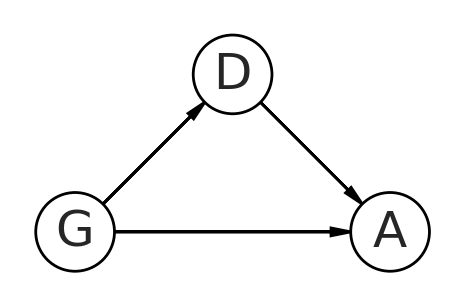

<IPython.core.display.Javascript object>

In [8]:
pipe_dag = CausalGraphicalModel(
    nodes=["G", "D", "A"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "G": (0, 0),
    "D": (1, 1),
    "A": (2, 0),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


## Naive approach

Before even tackling the DAG, I wanted to contrast it with what I would've done if I were naive to the methods of this chapter (or even the whole book). Here is how I'd approach it. I suppose I'd simply do a comparison of each department for gender.

In [9]:
df_grants["prop_awarded"] = df_grants["awards"] / df_grants["applications"]
df_grants.head()

,discipline,gender,applications,awards,prop_awarded
0,Chemical sciences,m,83,22,0.265060
1,Chemical sciences,f,39,10,0.256410
2,Physical sciences,m,135,26,0.192593
3,Physical sciences,f,39,9,0.230769
4,Physics,m,67,18,0.268657


<IPython.core.display.Javascript object>

Then I suppose I'd do like a difference in proportions test, like shown at the bottom of [this statsmodels z-test page](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html).

In [10]:
from statsmodels.stats.proportion import proportions_ztest

ztest_pval = list()
count_list = np.array(df_grants['awards'])
nobs_list = np.array(df_grants['applications'])
for i in range(0, len(df_grants), 2):
    #print(i)
    stat, pval = proportions_ztest(df_grants.loc[i : i + 1, "awards"], df_grants.loc[i:i+1, 'applications'])
    ztest_pval.append(pval)
    if df_grants.loc[i, "prop_awarded"] > df_grants.loc[i + 1, "prop_awarded"]:
        higher_gender = "M"
    else:
        higher_gender = 'F'
    print(df_grants.loc[i, "discipline"], '{0:0.3f}'.format(pval), higher_gender)
    


Chemical sciences 0.919 M
Physical sciences 0.600 F
Physics 0.766 M
Humanities 0.191 F
Technical sciences 0.356 F
Interdisciplinary 0.058 F
Earth/life sciences 0.035 M
Social sciences 0.107 M
Medical sciences 0.016 M


<IPython.core.display.Javascript object>

I might conclude that "Medical sciences" and "Interdisciplinary" have evidence of bias, but this would be unsatisfying of course. For one, I have ignored the raw counts (number of applications and awards). Intuitively, a higher n would give more confidence in the proportion. Now I can go deeper with the GLM tools I've learned in these chapters.

# Principled approach and seeing how entropy applies

Essentially, this is how we know the counts and have observed values for the number of awards.

[PSU Stat explanation](https://online.stat.psu.edu/stat504/lesson/6/6.1)

This took me a long time to wrap my head around... but the key is going back to one of the early lessons and thinking about model strategy. Think about what's known, unknown, what's the generative process, and think about what you're trying to find out.

Here, we're ultimately trying to find p.    

## Generalized linear model

The structure of the generalized linear model with a binomial likelihood is something like this:

$$y_i ∼ \text{Binomial}(n, pi) \tag{likelihood}$$
<br>
$$  f(p_i) = \text{logit}(p_i) = \alpha + \beta x_i \tag{link function}$$    

The **logit link** function can be expanded as the logit is defined as log-odds:

$$  \text{logit}(p_i) = \text{log}\frac{p_i}{1-p_i} \tag{link function}$$


We can then simply solve for \(p_i\):

$$  p_i = \frac{\text{exp}(\alpha + \beta x_i)}{1 + \text{exp}(\alpha + \beta x_i)} \tag{logistic or inverse-logit}$$

Here are some useful snippets from the book that resonated with me:

> A unit change in xi may produce a larger or smaller change in the probability pi, depending upon how far from zero the log-odds are.
<br>
...The key lesson for now is just that no regression coefficient, such as β, from a GLM ever produces a constant change on the outcome scale.
...Recall that we defined interaction (Chapter 8) as a situation in which the effect of a predictor depends upon the value of another predictor. Well now every predictor essentially interacts with itself, because the impact of a change in a predictor depends upon the value of the predictor before the change. More generally, every predictor variable effectively interacts with every other predictor variable, whether you explicitly model them as interactions or not. This fact makes the visualization of counter-factual predictions even more important for understanding what the model is telling you.

**When looking at the original problem, a question that occurred to me is: How is it that we're ultimately interested in proportions but the likelihood, which is a binomial distribution, has an x-axis of counts?**

As a result of starting with my naive approach, where my intuition was to calculate the proportions awarded for each gender, one of the insights I had just now is that the proportion in our GLM is not the outcome variable of the first likelihood function (which is a binominal distribution resulting in counts). Rather it is in the second likelihood function, the link function. The predictive plots in the book's examples all show proportions as the unit of interest, which makes sense. So how is it that we're modeling counts? (Why do we use  binomial rather than something like beta which does proportions as an outcome variable? I'm not sure.)

Here are some thoughts that occurred to me as I attempted to answer my own question:
1. Even if we were to use a beta distribution, we do not have the actual counts for successes/failures or total. In this example, it would be the number of awarded grants and total applications. The binomial distribution includes this information.
2. The observed data are counts. This approach at least satisfies one of the weaknesses I had in my naive approach (just doing a z-test of proportions).
3. The parameter $p_i$ is unknown and unobserved. It reminded me of [this slide](https://youtu.be/XoVtOAN0htU?list=PLDcUM9US4XdNM4Edgs7weiyIguLSToZRI&t=1422) in one of the first lectures, listing observed and unobserved variables and describing the generative relations as part of the construction perspective.

Other thoughts:
- Even if we "push things through the GLM" to make predictions, it still seems like proportions are what we evaluate and not counts, which is at the end of the predictive engine.

Let's proceed with the problem solving template that the book lays out, but we will come back to this.

## Counts vs. probability in likelihood

After asking the Discord channel and thinking things through, I'm beginning to understand a little bit more the role of the likelihood....but still have to think about it a lot.

I have to remember the definition of likelihood: it is the relative plausibility of an observation. The counts in this example are observed, hence the logic of using binomial.

In previous examples that were using Gaussian distribution, the units of the likelihood matched the units of our desired predictions.

Keep moving forward.

## Setting up the problem, gender term only

This setup and code was modeled on R code 11.29 from the book and also from the pymc repo.

Let's start first with a simple GLM that only focuses on gender. We have an aggregated binomial data structure and therefore the model looks like this:

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{GID[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 1.5) $$    

We first need to create index variables. We'll use `pd.Categorical`.

In [35]:
# Used categories argument to specify m as 0 and f as 1 per the book (1 and 2, respectively in R code)
df_grants["gender_code"] = pd.Categorical(
    df_grants["gender"], categories=["m", "f"]
).codes

<IPython.core.display.Javascript object>

Our dataframe now looks like this. Note that males are designated as 0 and females as 1.

In [36]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

In [280]:
glm1

<IPython.core.display.Javascript object>

In [37]:
with pm.Model() as glm1:
    #  Prior for the alpha term
    # a = pm.Normal("a", 0, 1.5, shape=2)   # My choice from UCB example
    # Changed due to solutions (from domain knowledge that less than half of applicants get awards)
    a = pm.Normal("a", -1, 1, shape=2)

    # The link function
    # Note difference from R code: logit(p) <- a[gid]
    p = pm.Deterministic("p", pm.math.invlogit(a[df_grants["gender_code"]]))

    # Likelihood
    award = pm.Binomial(
        "award", p=p, n=df_grants["applications"], observed=df_grants["awards"]
    )

    trace_glm1 = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


<IPython.core.display.Javascript object>

In [40]:
az.summary(trace_glm1, var_names=["a"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.533,0.065,-1.640,-1.431,0.001,0.001,3461.71,3461.710,3468.345,2876.233,1.000
a[1],-1.740,0.081,-1.861,-1.609,0.001,0.001,3294.33,3291.245,3295.279,2940.342,1.001


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

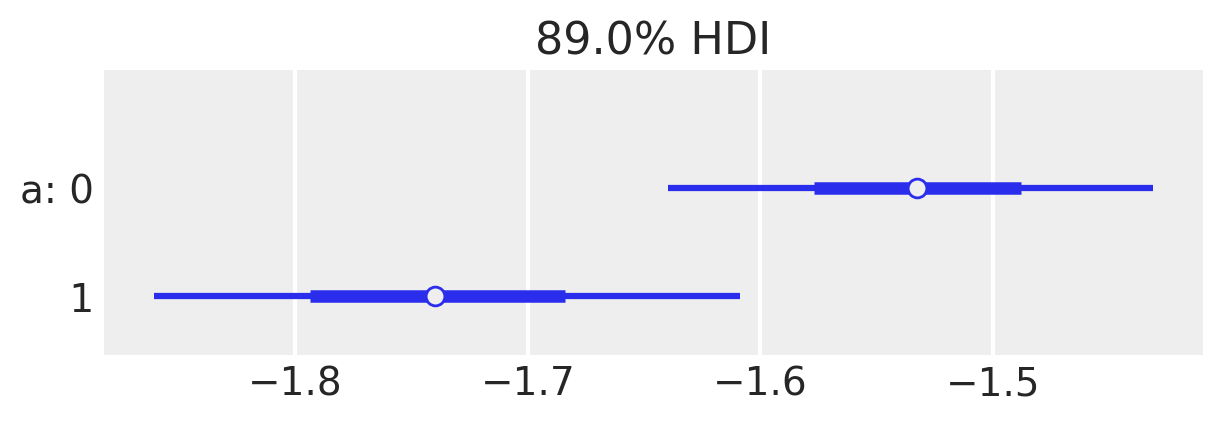

<IPython.core.display.Javascript object>

In [42]:
f, ax1 = plt.subplots(figsize=(6, 2))
az.plot_forest(trace_glm1, var_names=["a"], combined=True, ax=ax1)

### Interpreting differences

The posterior for male applicants trends higher than females although there is some overlap. Compute the contrast to get a better sense. Calculate contrasts on both the logit (relative) and outcome (absolute) scales.

In [43]:
# Take a look at the trace object
trace_glm1_df = trace_glm1.to_dataframe()
trace_glm1_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, p[0], 0)","(posterior, p[10], 10)","(posterior, p[11], 11)","(posterior, p[12], 12)","(posterior, p[13], 13)","(posterior, p[14], 14)",...,"(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy_error)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, step_size)","(sample_stats, tree_size)","(sample_stats, step_size_bar)"
0,0,0,-1.537064,-1.664010,0.176962,0.176962,0.159224,0.176962,0.159224,0.176962,...,768.601701,0.124197,1,0.124197,False,63.842621,-63.802686,1.417925,1.0,1.146981
1,0,1,-1.562078,-1.851493,0.173349,0.173349,0.135698,0.173349,0.135698,0.173349,...,768.602258,0.259713,2,0.259713,False,64.633434,-64.447520,1.417925,3.0,1.146981
2,0,2,-1.560664,-1.622147,0.173551,0.173551,0.164909,0.173551,0.164909,0.173551,...,768.602911,-0.186713,2,0.047203,False,65.099080,-64.520118,1.417925,3.0,1.146981
3,0,3,-1.466389,-1.718039,0.187492,0.187492,0.152124,0.187492,0.152124,0.187492,...,768.603459,-0.286899,2,-0.286899,False,64.713004,-63.933655,1.417925,3.0,1.146981
4,0,4,-1.466081,-1.739567,0.187539,0.187539,0.149368,0.187539,0.149368,0.187539,...,768.604005,-0.154756,2,-0.010150,False,64.114738,-63.909488,1.417925,3.0,1.146981


<IPython.core.display.Javascript object>

In [44]:
# Also interesting to see log-likelihood as one of the columns
# trace_glm1_df.columns

<IPython.core.display.Javascript object>

In [62]:
# a extracts from the posterior directly
diff_a = (
    trace_glm1_df[("posterior", "a[0]", 0)] - trace_glm1_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

Since we had built the model using logit p, we would have to do inverse logit (AKA logistic) on the parameter to get p back and calculate on the absolute scale. We'll use the scipy function.

In [63]:
# ?logistic

<IPython.core.display.Javascript object>

In [64]:
diff_p = logistic(trace_glm1_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glm1_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [66]:
az.summary({"diff_p": diff_p, "diff_a": diff_a}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_p,0.028,0.014,0.005,0.050
diff_a,0.207,0.104,0.049,0.378


<IPython.core.display.Javascript object>

### More about effect sizes

From McElreath:
<br>
"...Absolute effects [are] the difference a counter-factual change in a variable might make on an absolute scale of measurement, like the probability of an event... It is more common to see logistic regressions interpreted through relative effects. Relative effects are proportional changes in the odds of an outcome. If we change a variable and say the odds of an outcome double, then we are discussing relative effects. You can calculate these proportional odds relative effect sizes by simply exponentiating the parameter of interest.

**double-check this**

In [53]:
prop_odds = np.mean(np.exp(diff_a))
print("Proportional odds: {0:0.3f}".format(prop_odds))

Proportional odds: 1.237


<IPython.core.display.Javascript object>

| Scale of effect | parameter | variable  |  value here |
| --- | --- | ---|  --- |
| absolute | outcome | diff_p |  0.028 |
| relative | logit (log-odds?) | diff_a |  0.207  |
| relative | proportional odds | exp(diff_a) |  1.237 |

Here `diff_a` is the log-odds difference. It is positive (although the lower bound is barely above 0), indicating that there's a higher probability of admission for male applicants.

With regards to the last line of the table, this means that switching gender would yield about a 24% increase in odds of being awarded..

## Direct influence of gender, conditioning on discipline

Returning to the DAG, we would need to close the backdoor by conditioning on discipline to find the direct influence of gender.

In [55]:
# Used categories argument to specify m as 0 and f as 1 per the book (1 and 2, respectively in R code)
df_grants["discipline_code"] = pd.Categorical(df_grants["discipline"]).codes

<IPython.core.display.Javascript object>

In [56]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

In [57]:
df_grants["discipline_code"].unique()

array([0, 5, 6, 2, 8, 3, 1, 7, 4], dtype=int8)

<IPython.core.display.Javascript object>

In [19]:
with pm.Model() as glm2:
    #  Prior for the alpha and delta terms
    a = pm.Normal("a", -1, 1, shape=2)
    d = pm.Normal("d", 0, 1.5, shape=9)

    # The link function
    # Note difference from R code: logit(p) <- a[gid]
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(a[df_grants["gender_code"]] + d[df_grants["discipline_code"]]),
    )

    # Likelihood
    award = pm.Binomial(
        "award", p=p, n=df_grants["applications"], observed=df_grants["awards"]
    )

    trace_glm2 = pm.sample(
        1000, tune=1000, return_inferencedata=True
    )  # used arguments I've used before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [d, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
The number of effective samples is smaller than 10% for some parameters.


<IPython.core.display.Javascript object>

Note from solutions: "Those chains didn’t sample very efficiently. This is because the model is over-parameterized—it has more parameters than absolutely necessary. This doesn’t break it. It just makes
the sampling less efficient."

In [258]:
az.summary(trace_glm2, var_names=["a", "d"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.260,0.433,-1.985,-0.588,0.023,0.017,356.412,321.648,355.657,372.076,1.010
a[1],-1.402,0.434,-2.049,-0.653,0.023,0.017,369.448,337.019,369.473,393.786,1.010
d[0],0.256,0.471,-0.533,0.989,0.023,0.018,416.658,340.141,414.567,453.138,1.009
d[1],-0.080,0.453,-0.792,0.647,0.023,0.016,395.034,395.034,395.636,445.566,1.009
d[2],-0.314,0.449,-1.031,0.409,0.023,0.016,391.310,391.310,389.573,443.101,1.010
d[3],-0.361,0.472,-1.162,0.329,0.023,0.016,412.258,412.258,414.107,509.913,1.011
d[4],-0.416,0.444,-1.138,0.278,0.023,0.016,384.660,384.660,384.594,436.365,1.010
d[5],-0.099,0.465,-0.800,0.686,0.023,0.016,423.728,423.728,421.514,459.758,1.008
d[6],0.227,0.503,-0.601,0.999,0.024,0.018,437.778,413.065,437.600,590.560,1.009
d[7],-0.536,0.441,-1.209,0.210,0.023,0.016,381.198,381.198,380.644,390.792,1.009


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

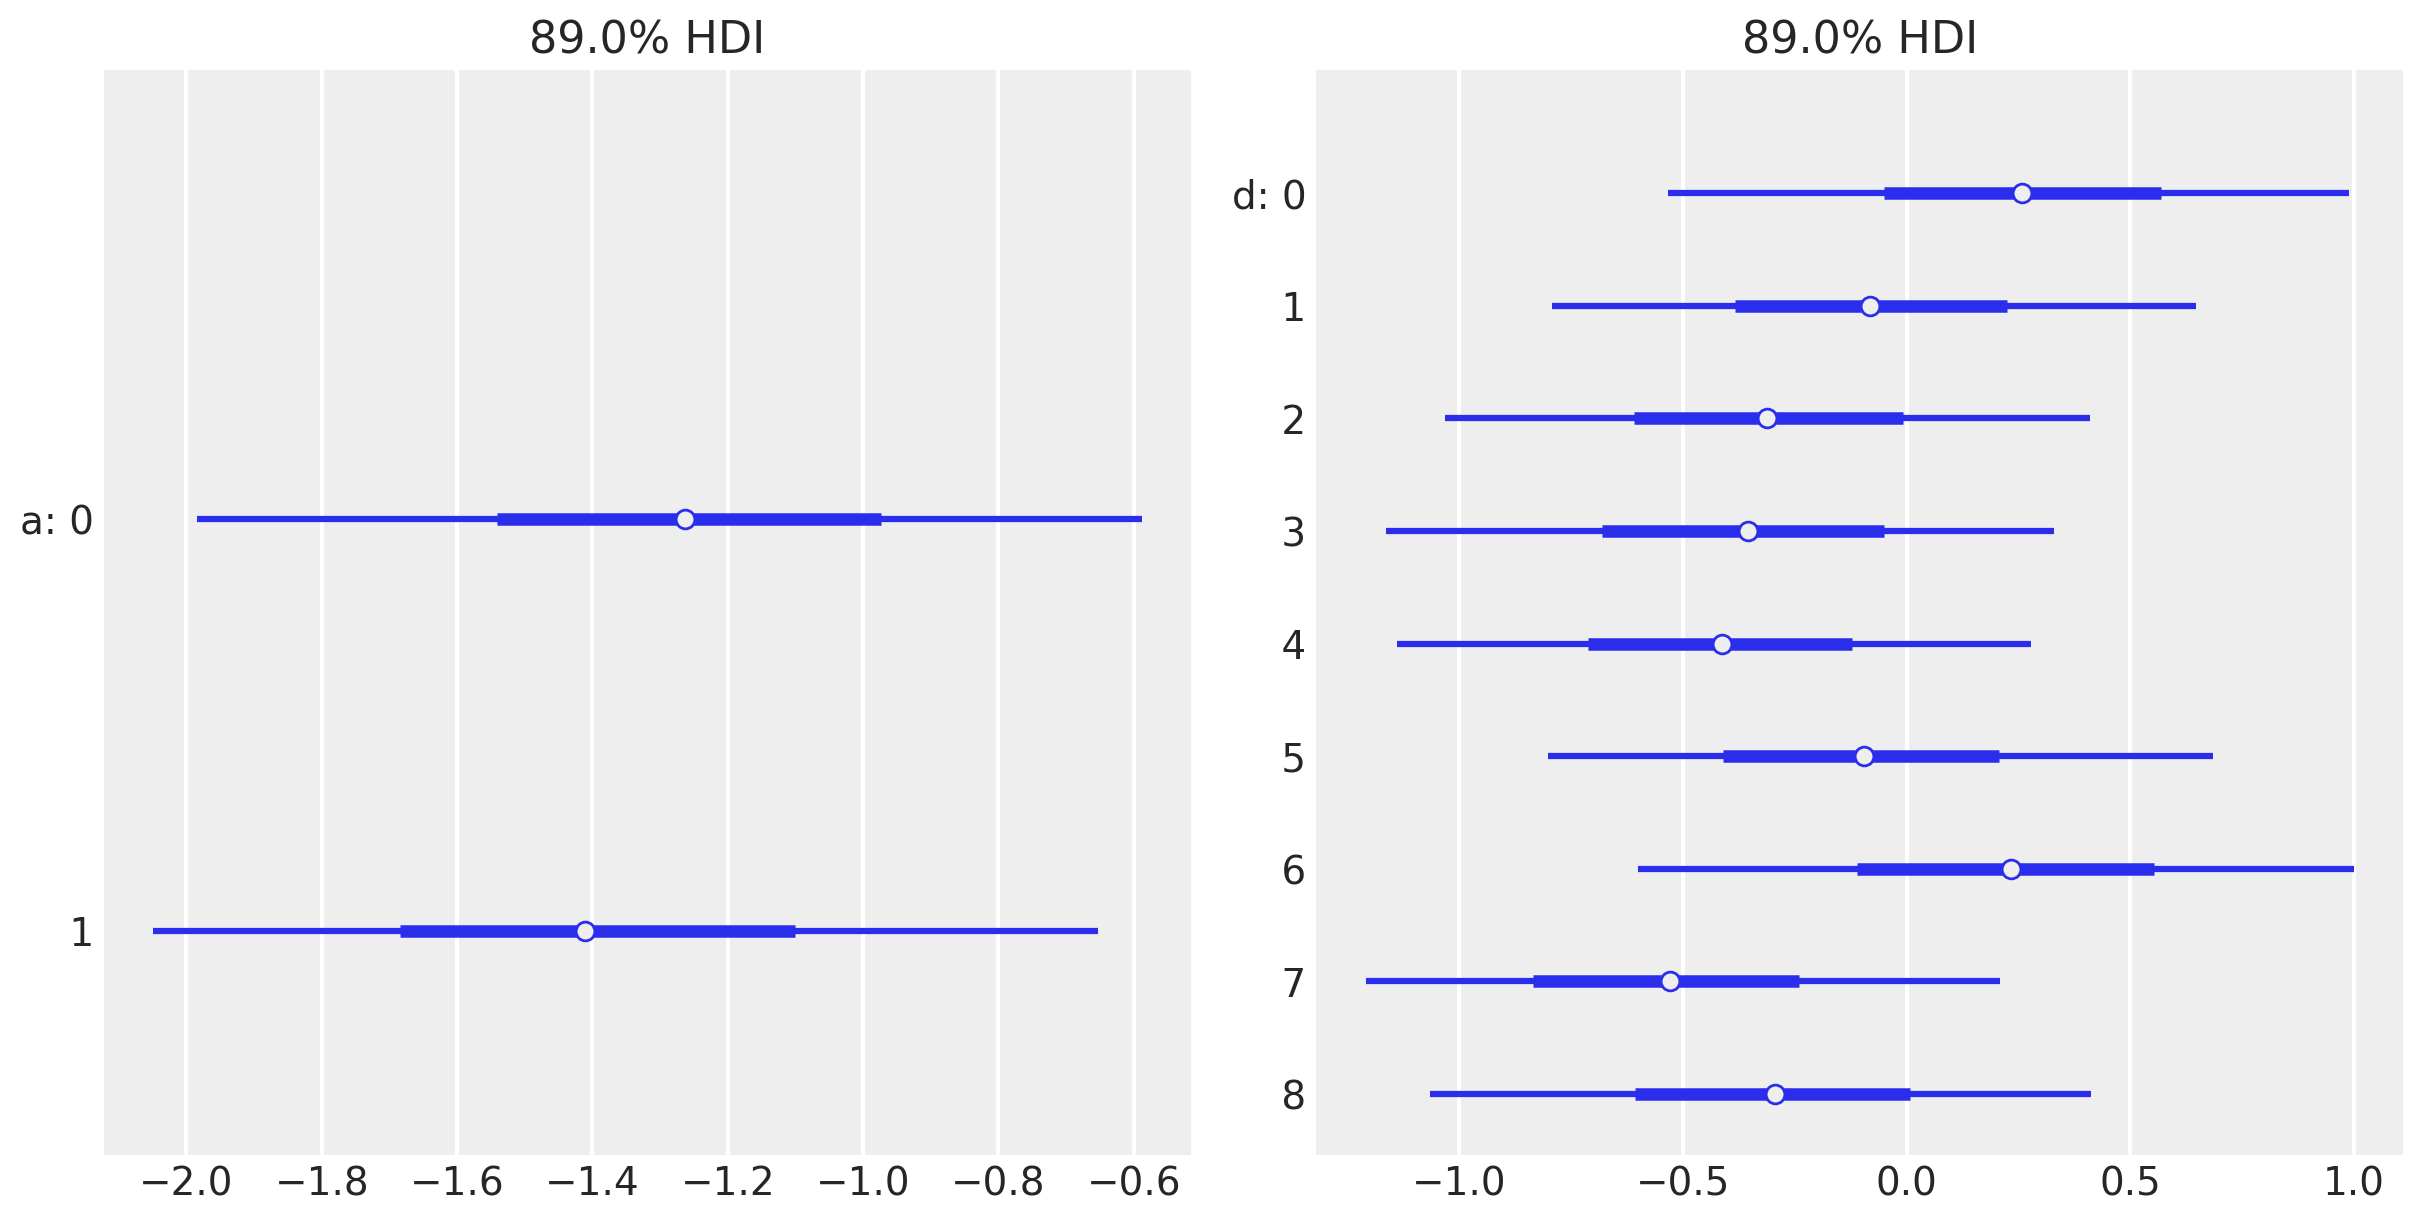

<IPython.core.display.Javascript object>

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
az.plot_forest(trace_glm2, var_names=["a"], combined=True, ax=ax1)
az.plot_forest(trace_glm2, var_names=["d"], combined=True, ax=ax2)

For the gender, shown on the left, we see that the differences between respective log-odds are smaller.

I'm showing the effect of discipline on the right subplot. Most log-odds are negative, but discipline 6 is positive, suggesting that, on average, applications to this discipline are awarded slightly more than 50% of the time. We'll return to this point.

Let's return to interpreting the gender differences and calculate contrasts properly.

### Interpreting differences

In [58]:
# Take a look at the trace object
trace_glm2_df = trace_glm2.to_dataframe()
trace_glm2_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, d[0], 0)","(posterior, d[1], 1)","(posterior, d[2], 2)","(posterior, d[3], 3)","(posterior, d[4], 4)","(posterior, d[5], 5)",...,"(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy_error)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, step_size)","(sample_stats, tree_size)","(sample_stats, step_size_bar)"
0,0,0,-1.244711,-1.304266,0.225946,-0.219058,-0.233938,-0.386399,-0.572113,-0.162285,...,10.949976,2.915981,3,-0.155245,False,71.000098,-66.443577,0.209726,7.0,0.216338
1,0,1,-2.297566,-2.428387,1.384511,1.092071,0.606298,0.691485,0.630743,0.639928,...,10.951106,0.976167,6,0.063577,False,74.423266,-70.592245,0.209726,47.0,0.216338
2,0,2,-2.254114,-2.343903,1.312178,0.926559,0.690306,0.764693,0.736964,0.755079,...,10.955951,0.515360,3,0.203250,False,75.845221,-70.097851,0.209726,7.0,0.216338
3,0,3,-2.173341,-2.350279,1.528494,0.846605,0.682161,0.760716,0.452235,0.675007,...,10.956840,-0.384688,3,-0.057300,False,74.791527,-71.684805,0.209726,7.0,0.216338
4,0,4,-2.151602,-2.382029,1.425929,0.756727,0.576211,0.722897,0.423929,0.727919,...,10.957710,0.473459,3,0.473459,False,75.701762,-73.223646,0.209726,7.0,0.216338


<IPython.core.display.Javascript object>

In [59]:
# a extracts from the posterior directly
diff_a2 = (
    trace_glm2_df[("posterior", "a[0]", 0)] - trace_glm2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [60]:
# convert from log-odds to odds
diff_p2 = logistic(trace_glm2_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glm2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [70]:
az.summary({"diff_p2": diff_p, "diff_a2": diff_a2}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_p2,0.028,0.014,0.005,0.050
diff_a2,0.142,0.106,-0.028,0.309


<IPython.core.display.Javascript object>

We see that the differences between gender are smaller although there's still a slight edge towards males.

On the absolute scale, males have a 2% advantage. On the relative scale, the odds are 0.139...

### Visualize within each department

Code taken from repo.

In [74]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

### Predictions

In [303]:
with glm2:
    ppc = pm.sample_posterior_predictive(
        trace_glm2, random_seed=RANDOM_SEED, var_names=["award", "p"]
    )

<IPython.core.display.Javascript object>

In [304]:
ppc

{'award': array([[18,  9, 28, ..., 55, 31, 44],
        [21, 12, 17, ..., 58, 34, 44],
        [22, 11, 25, ..., 53, 34, 34],
        ...,
        [37, 12, 26, ..., 30, 36, 50],
        [31, 14, 35, ..., 53, 33, 35],
        [21, 13, 22, ..., 62, 46, 51]]),
 'p': array([[0.26526811, 0.25382417, 0.19670831, ..., 0.13664613, 0.13981549,
         0.13280544],
        [0.28637491, 0.26040275, 0.16007924, ..., 0.13658481, 0.1588481 ,
         0.14213807],
        [0.28050944, 0.26274977, 0.18256959, ..., 0.13642219, 0.1798816 ,
         0.16701402],
        ...,
        [0.29541875, 0.25752246, 0.17200166, ..., 0.09862884, 0.19121972,
         0.16358666],
        [0.30486334, 0.2482912 , 0.18172517, ..., 0.13178139, 0.1592753 ,
         0.12486641],
        [0.28163589, 0.23727378, 0.17316441, ..., 0.1510227 , 0.19998097,
         0.16551731]])}

<IPython.core.display.Javascript object>

In [306]:
ppc["p"].shape

(4000, 18)

<IPython.core.display.Javascript object>

In [77]:
df_grants["applications"].values[None, :]

array([[ 83,  39, 135,  39,  67,   9, 230, 166, 189,  62, 105,  78, 156,
        126, 425, 409, 245, 260]])

<IPython.core.display.Javascript object>

In [82]:
pp_award = ppc / df_grants["applications"].values[None, :]

<IPython.core.display.Javascript object>

In [123]:
# trace_glm2_df.columns

<IPython.core.display.Javascript object>

In [97]:
pp_award.shape

(4000, 18)

<IPython.core.display.Javascript object>

In [95]:
df_grants.tail()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
13,Earth/life sciences,f,126,18,0.142857,1,1
14,Social sciences,m,425,65,0.152941,7,0
15,Social sciences,f,409,47,0.114914,7,1
16,Medical sciences,m,245,46,0.187755,4,0
17,Medical sciences,f,260,29,0.111538,4,1


<IPython.core.display.Javascript object>

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


[Text(-2.5, 0, ''),
 Text(0.0, 0, ''),
 Text(2.5, 0, ''),
 Text(5.0, 0, ''),
 Text(7.5, 0, ''),
 Text(10.0, 0, ''),
 Text(12.5, 0, ''),
 Text(15.0, 0, ''),
 Text(17.5, 0, ''),
 Text(20.0, 0, '')]

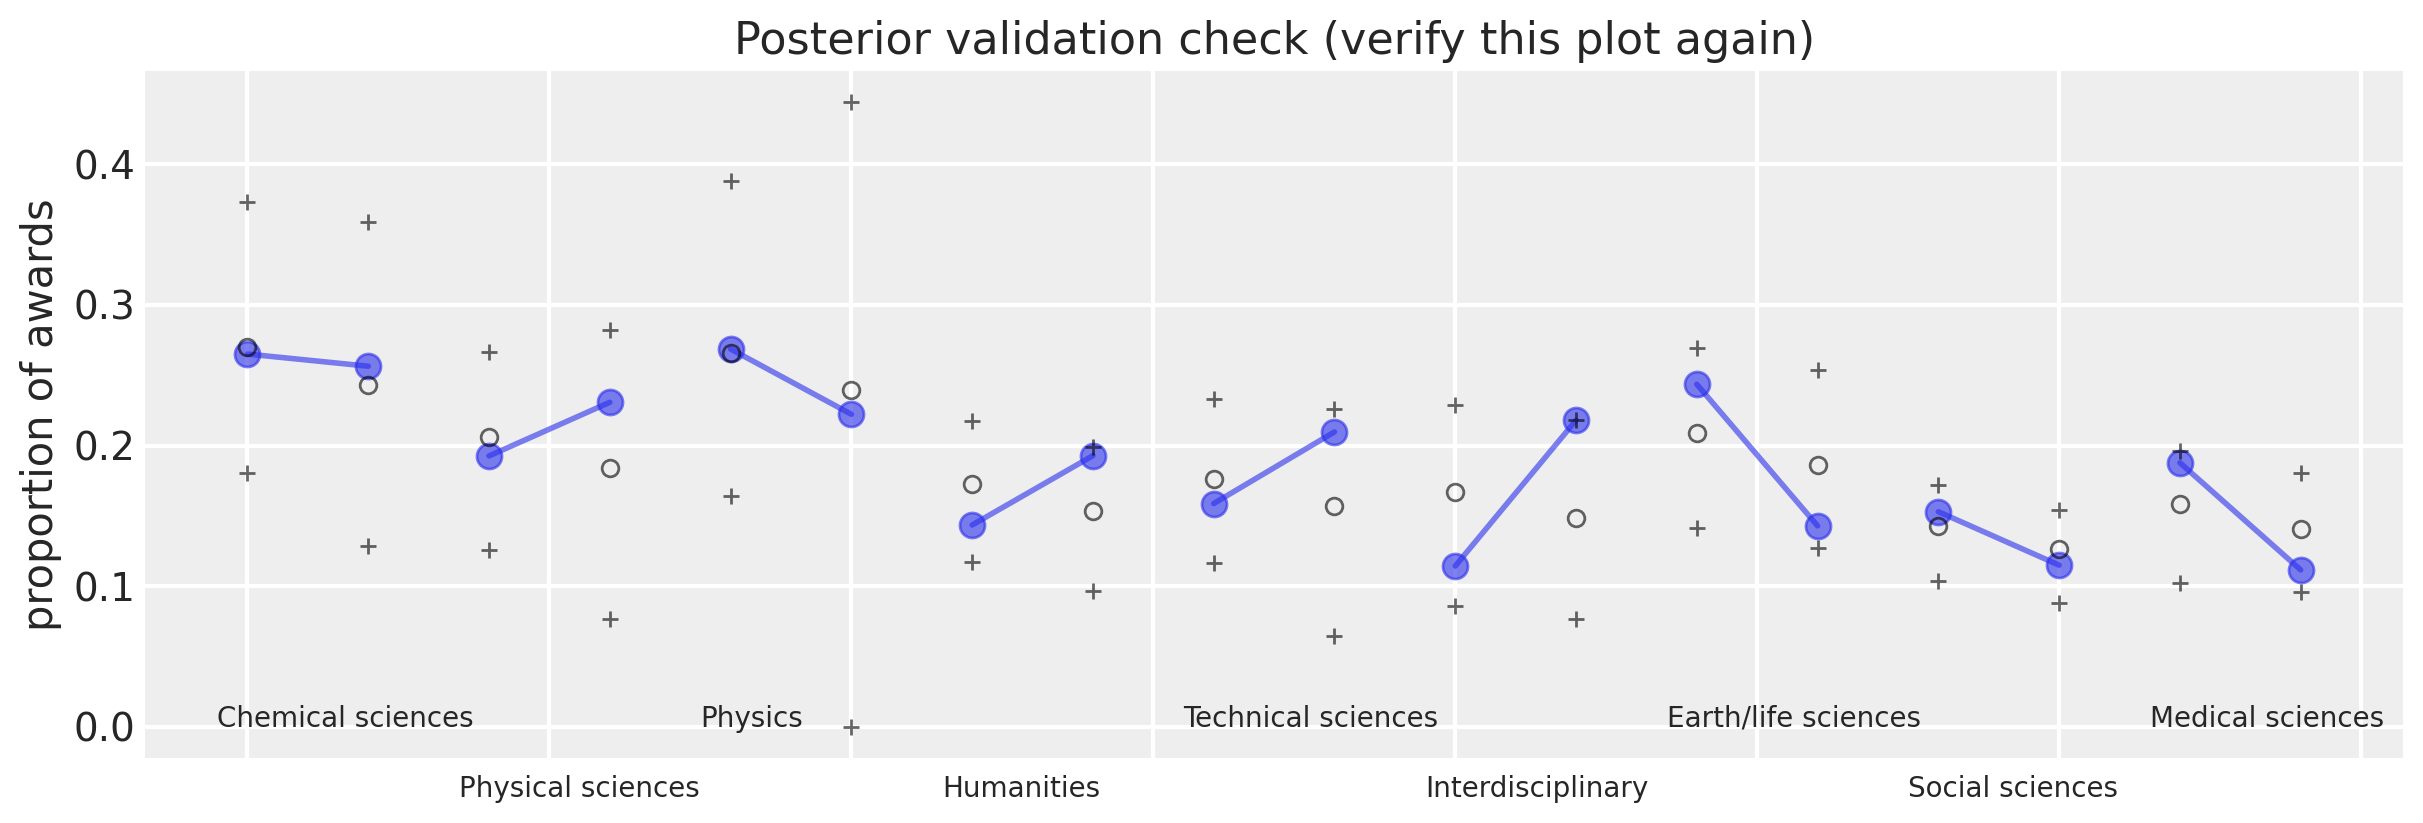

<IPython.core.display.Javascript object>

In [122]:
f, ax1 = plt.subplots(figsize=(12, 4))

# Iterate through each department
for i in range(9):
    x = 2 * i

    # print(x)

    y1 = df_grants["awards"][x] / df_grants["applications"][x]
    y2 = df_grants["awards"][x + 1] / df_grants["applications"][x + 1]

    ax1.plot([x, x + 1], [y1, y2], "-C0o", alpha=0.6, lw=2)
    if x % 4 == 0:
        ytext_val = 0
    else:
        ytext_val = -0.05
    ax1.text(
        x - 0.25,
        ytext_val,
        df_grants["discipline"][x],
        fontsize=10,
        rotation=0,
        ha="left",
    )

    ax1.plot(
        x,
        trace_glm2_df[("posterior", "p[" + str(x) + "]", x)].mean(0),
        "ko",
        fillstyle="none",
        ms=6,
        alpha=0.6,
    )

    ax1.plot(
        x + 1,
        trace_glm2_df[("posterior", "p[" + str(x + 1) + "]", x + 1)].mean(0),
        "ko",
        fillstyle="none",
        ms=6,
        alpha=0.6,
    )

ax1.plot([range(0, 18), range(0, 18)], az.hdi(pp_award).T, "k+", ms=6, alpha=0.6)

ax1.set_xlabel("")
ax1.set_ylabel("proportion of awards")
ax1.set_title("Posterior validation check (verify this plot again)")
ax1.set_xticklabels([])

## Follow-up

- I need to better understand relative/absolute and connect it to the logit/probability metrics.

- Also see about predictions versus observed.... predictions look worse for females in all discipliens.

# Question 2 (11H5)

Suppose that the NWO Grants sample has an unobserved confound that influences both choice of discipline and the probability of an award. One example of such a confound could be the career stage of each applicant. Suppose that in some disciplines, junior scholars apply for most of the grants. In other disciplines, scholars from all career stages compete. As a result, career stage influences discipline as well as the probability of being awarded a grant.

Add these influences to your DAG from Problem 1. What happens now when you condition on discipline? Does it provide an un-confounded estimate of the direct path from gender to an award? Why or why not? Justify your answer with the back-door criterion. Hint: This is structurally a lot like the grandparents-parentschildren-
neighborhoods example from a previous week.

If you have trouble thinking this though, try simulating fake data, assuming your DAG is true. Then analyze it using the model from Problem 1. What do you conclude? Is it possible for gender to have a real direct causal influence but for a regression conditioning on both gender and discipline to suggest zero influence?

## New DAG

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


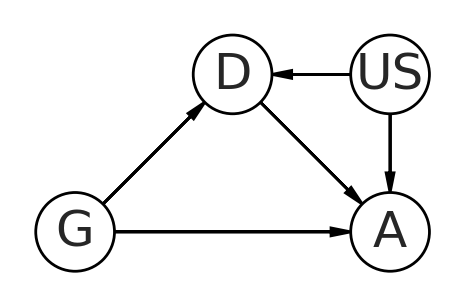

<IPython.core.display.Javascript object>

In [128]:
pipe_dag = CausalGraphicalModel(
    nodes=["G", "D", "A", "US"],
    edges=[
        ("G", "D"),
        ("D", "A"),
        ("G", "A"),
        ("US", "A"),
        ("US", "D"),
    ],
)
pgm = daft.PGM()

coordinates = {
    "G": (0, 0),
    "D": (1, 1),
    "A": (2, 0),
    "US": (2, 1),
}
for node in pipe_dag.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in pipe_dag.dag.edges:
    pgm.add_edge(*edge)
pgm.render()


In terms of the paths of G to A, we now have the following:

- G > A (direct)
- G > D > A (D acts as a pipe)
- G > D < US > A (D acts as a collider)

Therefore, we're "hurt" by the fact that we can't answer our question with satisfaction since there are problems whether we condition on D or not.

McElreath's suggestion: "What can be done in these situations? The best thing is to stop analyzing convenient,
confounded data and instead design a real study."

## Simulate data

In [130]:
from scipy.stats import bernoulli

<IPython.core.display.Javascript object>

In [129]:
df_grants.head()

,discipline,gender,applications,awards,prop_awarded,discipline_code,gender_code
0,Chemical sciences,m,83,22,0.265060,0,0
1,Chemical sciences,f,39,10,0.256410,0,1
2,Physical sciences,m,135,26,0.192593,5,0
3,Physical sciences,f,39,9,0.230769,5,1
4,Physics,m,67,18,0.268657,6,0


<IPython.core.display.Javascript object>

In [164]:
s_app_perc = (
    df_grants.groupby(["discipline"])["applications"].sum()
    / df_grants["applications"].sum()
).sort_values(ascending=False)

s_app_perc

discipline
Social sciences        0.295430
Medical sciences       0.178888
Humanities             0.140276
Earth/life sciences    0.099894
Technical sciences     0.088913
Interdisciplinary      0.064825
Physical sciences      0.061637
Chemical sciences      0.043216
Physics                0.026922
Name: applications, dtype: float64

<IPython.core.display.Javascript object>

In [159]:
df_grants["applications"].sum()

2823

<IPython.core.display.Javascript object>

Our dataframe would look something like this but we have to account for the career stage. I took a peek at the solutions for some hints of how to generate the data. A function to simulate Bernoulli looks like it can be relevant. Let's mimic the dataframe we have but this time disaggregate the data so that each row is a single applicant. We'll work with 3000 applicants, which is close to what the original data had.

In [191]:
df_grants2 = pd.DataFrame({"applicant": range(3000)})

<IPython.core.display.Javascript object>

Let's assign disciplines to the applicants with the same proportion as the original.



In [192]:
discipline_list = []
count = 0
for i, prop in enumerate(s_app_perc):
    disc = s_app_perc.index[i]
    mult_factor = int(np.ceil(prop * 3000))
    count += mult_factor
    discipline_list = discipline_list + [disc] * mult_factor

discipline_list = discipline_list[0:3000]
len(discipline_list)

df_grants2["discipline"] = discipline_list

<IPython.core.display.Javascript object>

## I was having difficulty with this problem and simulating data

# Question 3 (11H2)

The data contained in library(MASS);data(eagles) are records of salmon pirating attempts by Bald Eagles in Washington State. See ?eagles for details. While one eagle feeds, sometimes another will swoop in and try to steal the salmon from it. Call the feeding eagle the “victim” and the thief the “pirate.” Use the available data to build one or more binomial GLMs of successful pirating attempts, using size and age as predictors. Consider any relevant interactions

In [201]:
data_dir = "/Users/blacar/Documents/ds_projects/stats_rethinking/pymc3_ed_resources/resources/Rethinking/Data/"
df_eagles = pd.read_csv(data_dir + "eagles.csv", sep=";")

<IPython.core.display.Javascript object>

From R documentation:

```
y   Number of successful attempts.
n   Total number of attempts.
P   Size of pirating eagle (L = large, S = small).
A   Age of pirating eagle (I = immature, A = adult).
V   Size of victim eagle (L = large, S = small).
```

Start by encoding categorical variables.

In [205]:
# Make the older, bigger eagle a 1
df_eagles["P_code"] = pd.Categorical(df_eagles["P"], categories=["S", "L"]).codes
df_eagles["A_code"] = pd.Categorical(df_eagles["A"], categories=["I", "A"]).codes
df_eagles["V_code"] = pd.Categorical(df_eagles["V"], categories=["S", "L"]).codes

<IPython.core.display.Javascript object>

In [208]:
df_eagles.head()

,y,n,P,A,V,P_code,A_code,V_code
0,17,24,L,A,L,1,1,1
1,29,29,L,A,S,1,1,0
2,17,27,L,I,L,1,0,1
3,20,20,L,I,S,1,0,0
4,1,12,S,A,L,0,1,1


<IPython.core.display.Javascript object>

In [207]:
df_eagles.shape

(8, 8)

<IPython.core.display.Javascript object>

Interesting that the dataset (by number of rows) is not huge. I tried not to look at the data, but it's interesting that you can see some patterns already.

I would think that all variables would interact. A large pirating eagle would probably be more successful against a smaller victim eagle, regardless of age. But perhaps age also plays a role. Maybe older pirating eagles would have more experience after controlling for size, but would if the eagle is very old, then their age would be a detriment, but we only have "immature" and "adult" so we may not see this granularity.

## Pirating eagle size only model

Let's start with simpler GLM first, considering only the pirating eagles size before building a more complex interaction model.

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{P[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 2) $$    

I am calling "success" as getting a successful catch greater than 50% of the time, so therefore I think my prior is reasonable. (If \(\alpha\) is 0, then p is 0.5).

In [209]:
logistic(0)

0.5

<IPython.core.display.Javascript object>

In [210]:
with pm.Model() as glmE:
    #  Prior for the alpha term
    a = pm.Normal("a", 0, 2, shape=2)

    # The link function
    p = pm.Deterministic("p", pm.math.invlogit(a[df_eagles["P_code"]]))

    # Likelihood
    catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"])

    trace_glmE = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]
INFO:pymc3:NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


<IPython.core.display.Javascript object>

In [211]:
az.summary(trace_glmE, var_names=["a"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.925,0.283,-1.385,-0.491,0.005,0.004,3427.698,3221.965,3433.275,2960.227,1.003
a[1],1.586,0.271,1.183,2.037,0.005,0.003,3504.917,3338.255,3542.157,2364.839,1.003


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

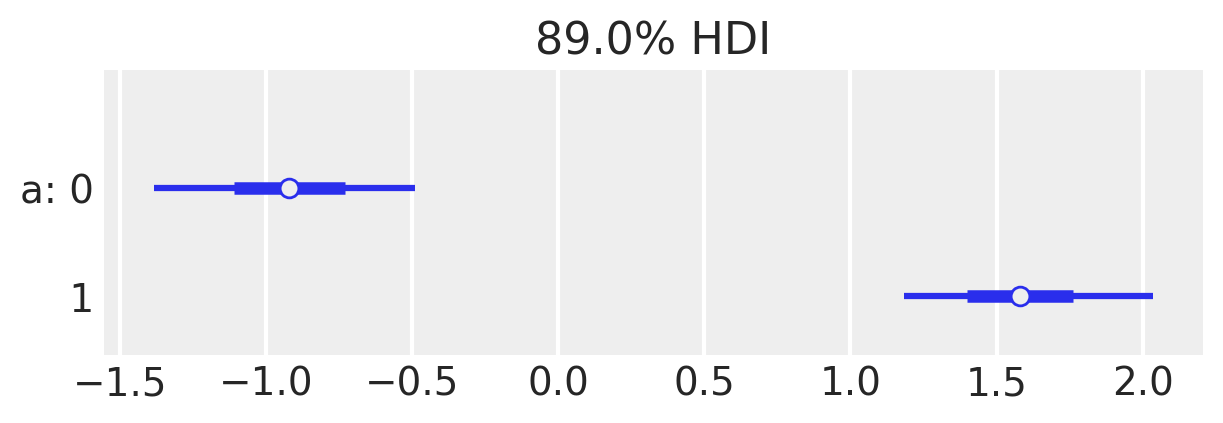

<IPython.core.display.Javascript object>

In [212]:
f, ax1 = plt.subplots(figsize=(6, 2))
az.plot_forest(trace_glmE, var_names=["a"], combined=True, ax=ax1)

Wow, there's an absolute monster effect of the size of the pirating eagle. Large eagles are successful almost all the time. Smaller eagles do not fail all the time though, suggesting there could be other factors to consider. Let's flesh out the rest of our analysis workflow.

### Interpreting differences

Calculate contrasts on both the logit (relative) and outcome (absolute) scales.

In [213]:
# Take a look at the trace object
trace_glmE_df = trace_glmE.to_dataframe()
trace_glmE_df.head()

,chain,draw,"(posterior, a[0], 0)","(posterior, a[1], 1)","(posterior, p[0], 0)","(posterior, p[1], 1)","(posterior, p[2], 2)","(posterior, p[3], 3)","(posterior, p[4], 4)","(posterior, p[5], 5)",...,"(sample_stats, perf_counter_start)","(sample_stats, max_energy_error)","(sample_stats, depth)","(sample_stats, energy_error)","(sample_stats, diverging)","(sample_stats, energy)","(sample_stats, lp)","(sample_stats, step_size)","(sample_stats, tree_size)","(sample_stats, step_size_bar)"
0,0,0,-0.572979,1.214593,0.771111,0.771111,0.771111,0.771111,0.360550,0.360550,...,39078.471380,0.224371,2,0.224371,False,52.013542,-51.313130,1.749953,3.0,1.154463
1,0,1,-0.755453,2.015282,0.882392,0.882392,0.882392,0.882392,0.319634,0.319634,...,39078.471991,-0.128704,2,-0.128704,False,51.980396,-51.178683,1.749953,3.0,1.154463
2,0,2,-1.032207,1.864016,0.865764,0.865764,0.865764,0.865764,0.262656,0.262656,...,39078.472564,-0.198516,1,-0.198516,False,51.092169,-50.377461,1.749953,1.0,1.154463
3,0,3,-0.804626,1.094242,0.749180,0.749180,0.749180,0.749180,0.309037,0.309037,...,39078.472964,0.327857,2,0.327857,False,51.527745,-51.446959,1.749953,3.0,1.154463
4,0,4,-0.854982,1.898821,0.869758,0.869758,0.869758,0.869758,0.298389,0.298389,...,39078.473687,0.606237,2,-0.049751,False,52.755851,-50.451126,1.749953,3.0,1.154463


<IPython.core.display.Javascript object>

In [215]:
# a extracts from the posterior directly
diff_aE = (
    trace_glmE_df[("posterior", "a[0]", 0)] - trace_glmE_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [216]:
diff_pE = logistic(trace_glmE_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glmE_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [217]:
az.summary({"diff_pE": diff_pE, "diff_aE": diff_aE}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_pE,-0.539,0.068,-0.641,-0.425
diff_aE,-2.511,0.390,-3.091,-1.861


<IPython.core.display.Javascript object>

This is taking the difference of the smaller pirating eagle minus larger pirating eagle.

The first is on the absolute (proportional scale) where, if a small eagle can switch size to being bigger, they would be successful by nearly 54 percentage points (**verify interpretation**).

And on the relative scale switching to being big would increase odds by 2.5.

## Pirating and victim size model

Let's level up the complexity and add another term, the size of the victim eagle.

$$ A_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = \alpha_{P[i]} + \omega_{V[i]} $$
$$ \alpha_j \sim \text{Normal}(0, 2) $$
$$ \omega_k \sim \text{Normal}(0.25, 2) $$

I'm arbitrarily using omega as the coefficient for the victim eagle size. I would think that pirating eagles would be more successful with smaller victims and so I will have my prior reflect that.

In [289]:
glmE2

<IPython.core.display.Javascript object>

In [288]:
with pm.Model() as glmE2:
    #  Prior for the alpha and omega terms
    a = pm.Normal("a", 0, 2, shape=2)
    o = pm.Normal("o", 0.25, 2, shape=2)

    # The link function
    p = pm.Deterministic(
        "p", pm.math.invlogit(a[df_eagles["P_code"]] + o[df_eagles["V_code"]])
    )

    # Likelihood
    catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"])

    trace_glmE2 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [o, a]
INFO:pymc3:NUTS: [o, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

**Check the warning messages. Make sure the chain is okay.**

In [290]:
az.summary(trace_glmE2, var_names=["a", "o"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-1.578,1.110,-3.324,0.161,0.034,0.024,1063.790,1031.163,1063.346,1102.143,1.004
a[1],2.404,1.120,0.483,4.065,0.033,0.023,1152.230,1152.230,1150.709,1079.694,1.001
o[0],2.924,1.134,1.189,4.723,0.035,0.025,1046.983,1046.983,1044.698,1477.078,1.006
o[1],-1.721,1.107,-3.435,0.048,0.033,0.023,1158.992,1158.992,1163.173,1112.662,1.001


<IPython.core.display.Javascript object>

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

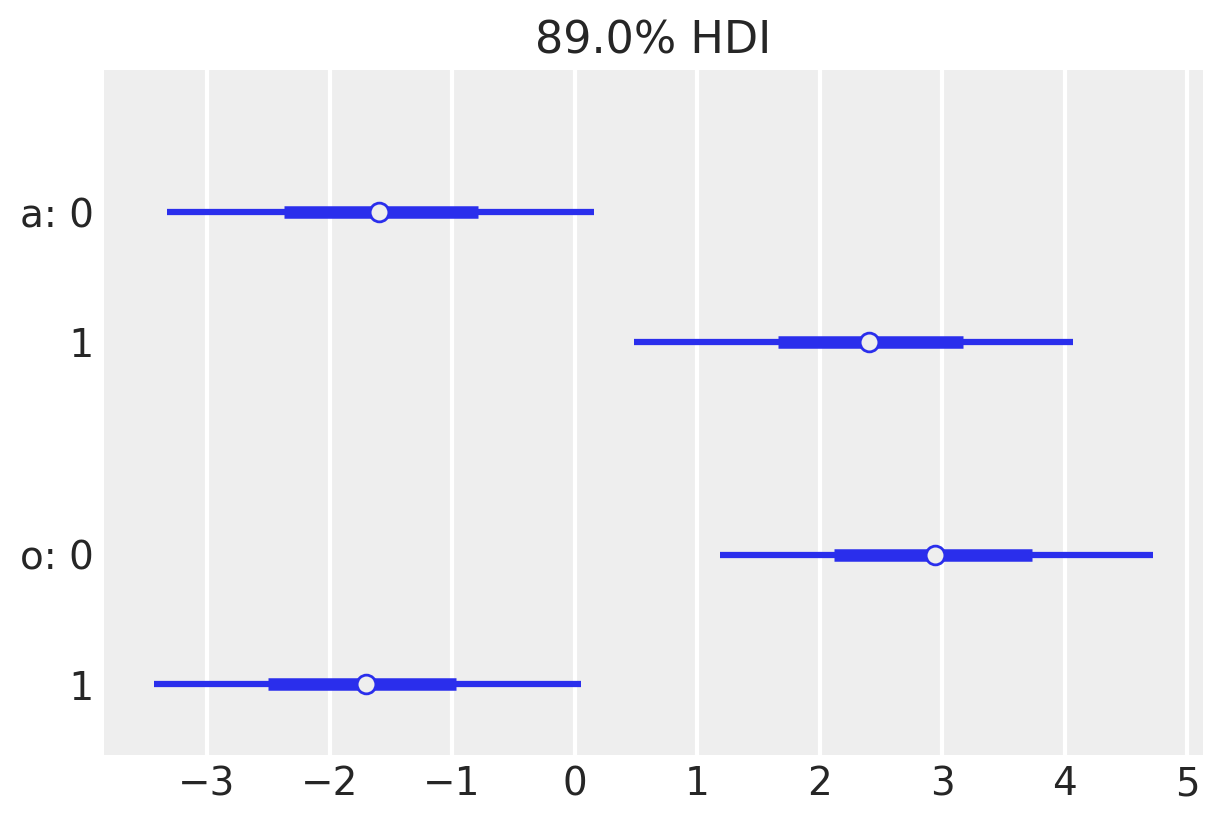

<IPython.core.display.Javascript object>

In [291]:
f, ax1 = plt.subplots(figsize=(6, 4))
az.plot_forest(trace_glmE2, var_names=["a", "o"], combined=True, ax=ax1)

Still a big effect of the size of the pirating eagle and now we have confirmation that having a smaller victim also leads to more success for the pirating eagle.

### Interpreting differences

Calculate contrasts on both the logit (relative) and outcome (absolute) scales.

In [221]:
# Take a look at the trace object
trace_glmE2_df = trace_glmE2.to_dataframe()

<IPython.core.display.Javascript object>

In [223]:
# a extracts from the posterior directly
diff_a2E = (
    trace_glmE2_df[("posterior", "a[0]", 0)] - trace_glmE2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [225]:
diff_p2E = logistic(trace_glmE2_df[("posterior", "a[0]", 0)]) - logistic(
    trace_glmE2_df[("posterior", "a[1]", 1)]
)

<IPython.core.display.Javascript object>

In [226]:
diff_oE = (
    trace_glmE2_df[("posterior", "o[0]", 0)] - trace_glmE2_df[("posterior", "o[1]", 1)]
)

<IPython.core.display.Javascript object>

In [227]:
diff_p2oE = logistic(trace_glmE2_df[("posterior", "o[0]", 0)]) - logistic(
    trace_glmE2_df[("posterior", "o[1]", 1)]
)

<IPython.core.display.Javascript object>

In [228]:
az.summary({"diff_p2oE": diff_p2oE, "diff_oE": diff_oE}, kind="stats", round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%
diff_p2oE,0.724,0.135,0.526,0.909
diff_oE,4.675,0.833,3.350,5.952


<IPython.core.display.Javascript object>

This model has both pirating and victim eagle size but if we just look at the victim size, we see an equally big effect as just looking at the pirating eagle.

### Predictions not working! Why?

For some reason, model wasn't saving? If it doesn't return the model you define, something's wrong.

In [292]:
glmE2

<IPython.core.display.Javascript object>

In [293]:
with glmE2:
    ppc = pm.sample_posterior_predictive(trace_glmE2, random_seed=RANDOM_SEED)

ppc

{'catches': array([[16, 29, 14, ..., 16,  0,  4],
        [13, 29, 20, ...,  9,  0,  4],
        [14, 28, 19, ..., 12,  0,  2],
        ...,
        [12, 29,  9, ..., 10,  0,  3],
        [13, 29, 13, ..., 10,  2,  4],
        [19, 29, 18, ..., 14,  0,  1]])}

<IPython.core.display.Javascript object>

## Interaction model

Let's now consider interactions. We'll add the remaining age term, but also add an interaction. I think it only makes sense to consider interaction between pirating size and pirating age.

I'll change my coefficient terms to the variable names in the dataframe. They're all categorical anyway.

$$ M_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = PS[i] + Age[i] + VS[i] + PS[i]*Age[i] $$
$$ PS_j \sim \text{Normal}(0, 2) $$
$$ VS_k \sim \text{Normal}(0.25, 2) $$
$$ Age_l \sim \text{Normal}(0, 2) $$

(I'm not sure what the right subscripts are.) For the prior for age, I'd suspect adults would be better, but I'll keep this broad.

For interactions of two categorical variables, I'm not sure how this will work so I'll just do a best guess.

In [232]:
with pm.Model() as glmE3:
    # Note new terms. I'm using dataframe definitions
    ps = pm.Normal("ps", 0, 2, shape=2)
    vs = pm.Normal("vs", 0.25, 2, shape=2)
    age = pm.Normal("age", 0, 2, shape=2)

    # The link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ps[df_eagles["P_code"]]
            + age[df_eagles["A_code"]]
            + vs[df_eagles["V_code"]]
            + ps[df_eagles["P_code"]] * age[df_eagles["A_code"]]
        ),
    )

    # Likelihood
    catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"])

    trace_glmE3 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, vs, ps]
INFO:pymc3:NUTS: [age, vs, ps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 140 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.3521464464828634, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.604405540304085, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than

<IPython.core.display.Javascript object>

**Got a lot of warnings**

In [233]:
az.summary(trace_glmE3, var_names=["ps", "vs", "age"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ps[0],-2.192,1.194,-3.990,-0.529,0.265,0.190,20.275,20.275,24.789,748.521,1.111
ps[1],-0.072,0.957,-1.317,1.397,0.066,0.047,207.619,207.619,213.832,518.368,1.134
vs[0],4.135,1.510,1.710,6.467,0.277,0.213,29.746,25.685,30.799,262.119,1.093
vs[1],-0.367,1.644,-2.724,2.006,0.355,0.254,21.452,21.452,28.188,598.480,1.105
age[0],1.901,1.344,-0.071,4.060,0.465,0.403,8.372,6.140,10.410,15.901,1.302
age[1],1.232,1.558,-0.543,3.982,0.621,0.515,6.307,5.174,8.595,14.422,1.389


<IPython.core.display.Javascript object>

In [257]:
postpred

{}

<IPython.core.display.Javascript object>

In [ ]:
with glm2:
    ppc = pm.sample_posterior_predictive(
        trace_glm2, random_seed=RANDOM_SEED, var_names=["award"]
    )["award"]

# Looked at solutions

His implementation:

```
d <- eagles
d$pirateL <- ifelse( d$P=="L" , 1 , 0 )
d$victimL <- ifelse( d$V=="L" , 1 , 0 )
d$pirateA <- ifelse( d$A=="A" , 1 , 0 )

f <- alist(
        y ~ dbinom( n , p ),
        logit(p) <- a + bP*pirateL + bV*victimL + bA*pirateA +
        bPV*pirateL*victimL + bAV*pirateA*victimL ,
        a ~ dnorm(0,1.5),
        c(bP,bV,bA,bPV,bAV) ~ dnorm(0,1) )
```

Things he did differently:

- narrower priors with SD 1 (regularized)
- in interaction model, he had an interaction term for age and victim size.
- he used dummy variables, not index variables. this allowed him to write his equation more simply... when it's 0, the term goes away which is okay here.
- made plots to visualize predictions, both for p and for counts

## Re-doing interaction model after following solutions

We'll do interactions and prior that the solution used. I'll stick with the index variable approach but we should theoretically get the same answer.

$$ M_i \sim \text{Binomial}(N_i, p_i) $$
$$ \text{logit}(p_i) = PS[i] + VS[k] + Age[l] + PS[i]*VS[j] + Age[l]*VS[j] $$
$$ PS_j \sim \text{Normal}(0, 1) $$
$$ VS_k \sim \text{Normal}(0, 1) $$
$$ Age_l \sim \text{Normal}(0, 1) $$

(I'm not sure what the right subscripts are.) For the prior for age, I'd suspect adults would be better, but I'll keep this broad.

For interactions of two categorical variables, I'm not sure how this will work so I'll just do a best guess.

In [398]:
with pm.Model() as glmE4:
    # Note new terms. I'm using dataframe definitions
    ps = pm.Normal("ps", 0, 1, shape=2)
    vs = pm.Normal("vs", 0, 1, shape=2)
    age = pm.Normal("age", 0, 1, shape=2)

    # The link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            ps[df_eagles["P_code"]]
            + vs[df_eagles["V_code"]]
            + age[df_eagles["A_code"]]
            + ps[df_eagles["P_code"]] * vs[df_eagles["V_code"]]
            + age[df_eagles["A_code"]] * vs[df_eagles["V_code"]]
        ),
    )

    # Likelihood
    catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"])

    trace_glmE4 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, vs, ps]
INFO:pymc3:NUTS: [age, vs, ps]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


<IPython.core.display.Javascript object>

**Got some warnings**

In [399]:
az.summary(trace_glmE4, round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
ps[0],-0.974,0.562,-1.893,-0.122,0.018,0.013,1016.076,988.308,1022.566,1404.493,1.002
ps[1],1.603,0.718,0.459,2.753,0.022,0.015,1082.439,1082.439,1040.671,860.780,1.004
vs[0],1.745,0.644,0.671,2.695,0.020,0.016,997.187,785.414,1130.407,608.232,1.005
vs[1],-0.411,0.175,-0.688,-0.159,0.006,0.004,760.068,760.068,995.125,477.266,1.004
age[0],-0.416,0.574,-1.337,0.480,0.017,0.012,1158.163,1158.163,1159.120,1300.646,1.004
age[1],1.070,0.623,0.121,2.090,0.019,0.013,1092.622,1092.622,1091.393,1476.908,1.001
p[0],0.736,0.075,0.620,0.856,0.001,0.001,3087.753,3020.784,3056.624,2920.264,1.001
p[1],0.999,0.002,0.998,1.000,0.000,0.000,2804.150,2798.352,2296.844,2089.732,1.000
p[2],0.553,0.065,0.453,0.656,0.001,0.001,4012.519,3950.352,4012.845,2971.582,1.000
p[3],0.980,0.027,0.950,1.000,0.000,0.000,3039.180,3039.180,2653.896,2141.451,1.001


<IPython.core.display.Javascript object>

### Posterior predictions

In [400]:
glmE4

<IPython.core.display.Javascript object>

In [402]:
with glmE4:
    ppc4 = pm.sample_posterior_predictive(
        trace=trace_glmE4, var_names=["p", "catches"], random_seed=55
    )
ppc4

{'p': array([[0.78762762, 0.99990629, 0.53601979, ..., 0.90398233, 0.19197403,
         0.05000631],
        [0.6635649 , 0.9994606 , 0.5128221 , ..., 0.89394003, 0.26677849,
         0.25807668],
        [0.85707234, 0.99980311, 0.5677638 , ..., 0.87970076, 0.16204477,
         0.03930356],
        ...,
        [0.78893296, 0.99785493, 0.53087026, ..., 0.87244523, 0.2233738 ,
         0.14701848],
        [0.81158206, 0.99806512, 0.56141434, ..., 0.81031057, 0.20087647,
         0.10701985],
        [0.84644285, 0.99966977, 0.57397843, ..., 0.91851357, 0.20080352,
         0.09365267]]),
 'catches': array([[21, 29, 15, ..., 15,  8,  0],
        [19, 29, 18, ..., 14, 10,  2],
        [16, 29, 16, ..., 14,  1,  0],
        ...,
        [20, 28, 23, ..., 14,  5,  0],
        [17, 29, 16, ..., 12,  5,  1],
        [21, 29, 16, ..., 14,  6,  0]])}

<IPython.core.display.Javascript object>

### Plots doing my way

In [406]:
# predictions
pred_mean4 = ppc4["p"].mean(axis=0)
df_eagles["prop_pred4"] = pred_mean4
df_eagles[["lower_b4", "upper_b4"]] = az.hdi(ppc4["p"])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<IPython.core.display.Javascript object>

In [407]:
df_eagles

,y,n,P,A,V,P_code,A_code,V_code,prop_obs,prop_pred,lower_b,upper_b,prop_pred4,lower_b4,upper_b4
0,17,24,L,A,L,1,1,1,0.708333,0.719807,0.592875,0.846169,0.735899,0.619657,0.855689
1,29,29,L,A,S,1,1,0,1.000000,0.980485,0.963419,0.997294,0.999140,0.998063,1.000000
2,17,27,L,I,L,1,0,1,0.629630,0.604916,0.474857,0.739129,0.552509,0.452577,0.655782
3,20,20,L,I,S,1,0,0,1.000000,0.923357,0.865116,0.981337,0.979516,0.949558,1.000000
4,1,12,S,A,L,0,1,1,0.083333,0.138587,0.044132,0.230394,0.405772,0.336353,0.474422
5,15,16,S,A,S,0,1,0,0.937500,0.825161,0.717592,0.935543,0.845191,0.724987,0.986683
6,0,28,S,I,L,0,0,1,0.000000,0.085417,0.026170,0.139285,0.228664,0.162133,0.295194
7,1,4,S,I,S,0,0,0,0.250000,0.533154,0.340693,0.717138,0.154558,0.000821,0.320808


<IPython.core.display.Javascript object>

In [408]:
xticklabels = (df_eagles["P"] + df_eagles["A"] + df_eagles["V"]).tolist()
xticklabels

['LAL', 'LAS', 'LIL', 'LIS', 'SAL', 'SAS', 'SIL', 'SIS']

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'My figure')

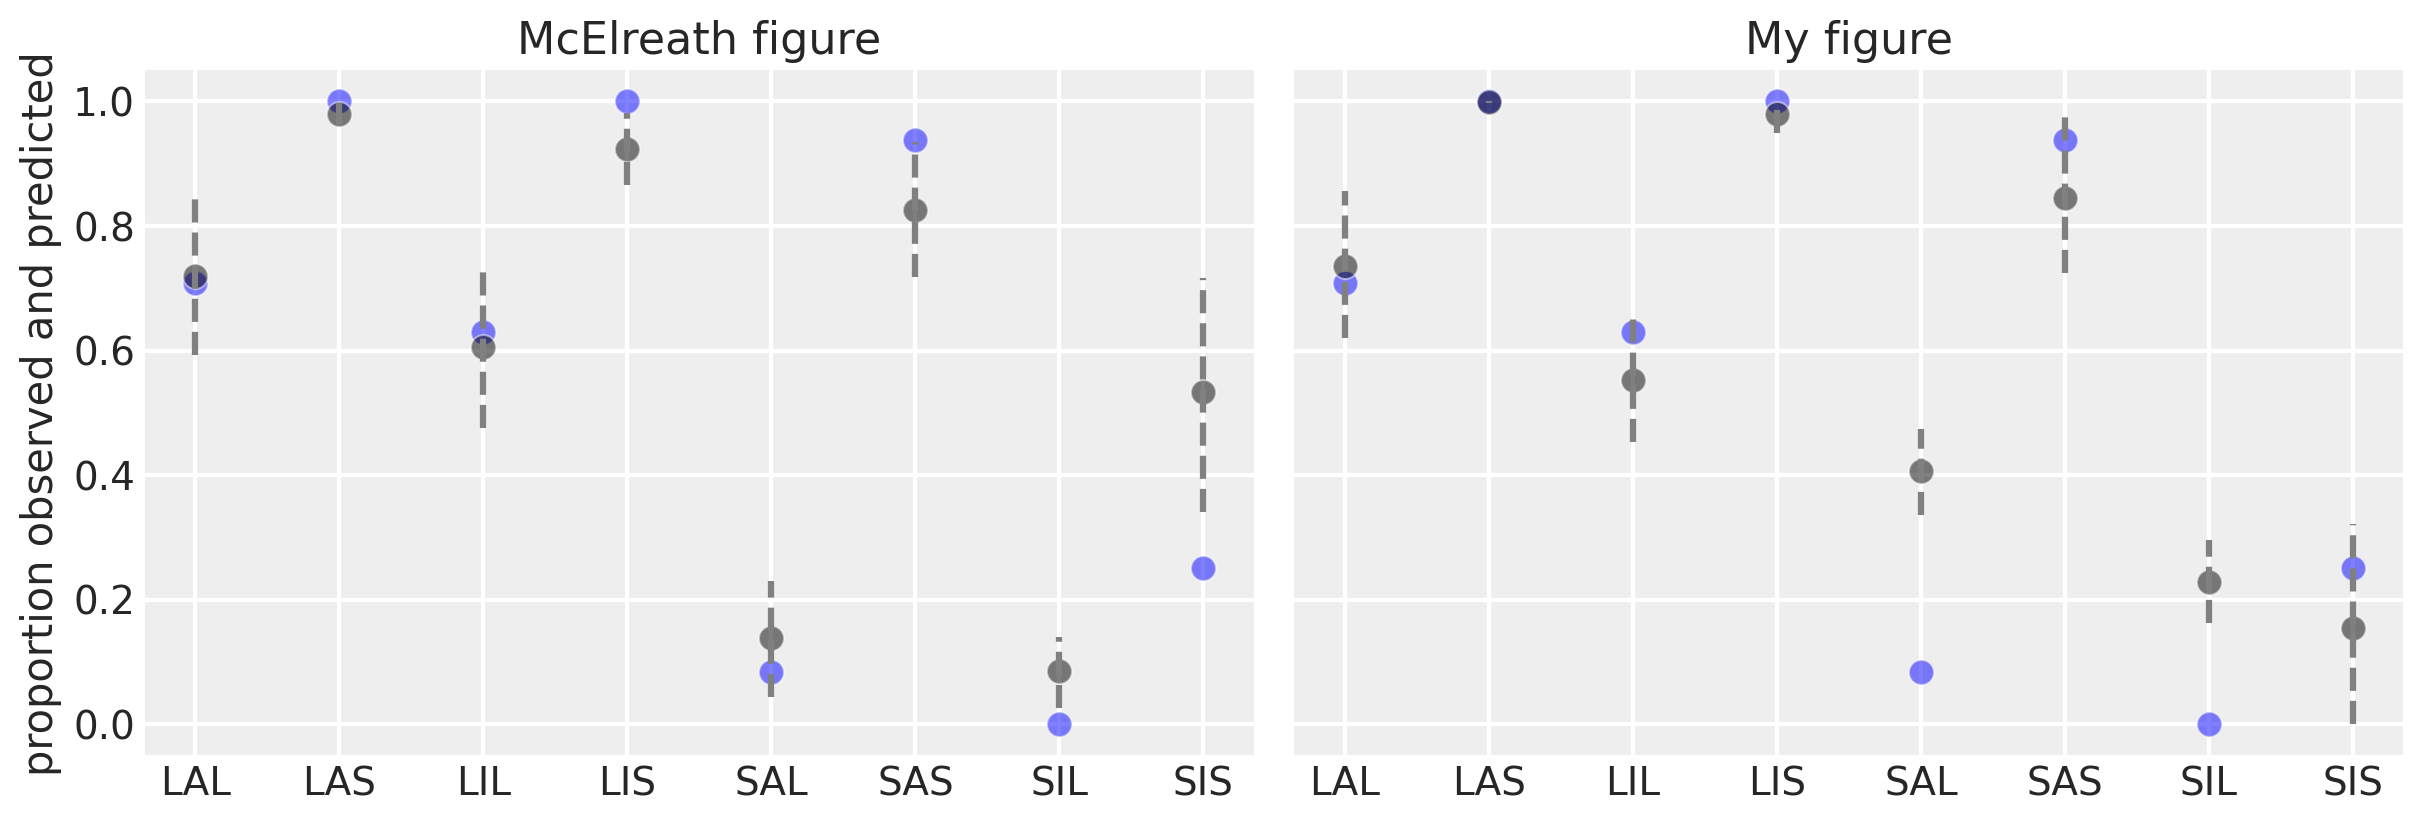

<IPython.core.display.Javascript object>

In [411]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# McElreath figure   ------
sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_obs",
    ax=ax1,
    color="blue",
    alpha=0.5,
)

sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_pred",
    ax=ax1,
    color="black",
    alpha=0.5,
)

ax1.vlines(
    x=range(len(df_eagles)),
    ymin=df_eagles["lower_b"],
    ymax=df_eagles["upper_b"],
    color="gray",
    linestyle="dashed",
)

# Rename xticklabels
ax1.set_xticks(range(0, 8))  # Necessary to set proper positions
ax1.set_xticklabels(xticklabels)
ax1.set_ylabel("proportion observed and predicted")
ax1.set_title("McElreath figure")


# My figure   ------
sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_obs",
    ax=ax2,
    color="blue",
    alpha=0.5,
)

sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_pred4",
    ax=ax2,
    color="black",
    alpha=0.5,
)

ax2.vlines(
    x=range(len(df_eagles)),
    ymin=df_eagles["lower_b4"],
    ymax=df_eagles["upper_b4"],
    color="gray",
    linestyle="dashed",
)

# Rename xticklabels
ax2.set_xticks(range(0, 8))  # Necessary to set proper positions
ax2.set_xticklabels(xticklabels)
ax2.set_ylabel("proportion observed and predicted")
ax2.set_title("My figure")

## What am I doing that isn't right?

## Doing R solution exactly in pymc

In [283]:
glmE5

<IPython.core.display.Javascript object>

In [282]:
with pm.Model() as glmE5:
    # Note new terms. I'm using dataframe definitions
    a = pm.Normal("a", 0, 1)
    bP = pm.Normal("bP", 0, 1)
    bV = pm.Normal("bV", 0, 1)
    bA = pm.Normal("bA", 0, 1)
    bPV = pm.Normal("bPV", 0, 1)
    bAV = pm.Normal("bAV", 0, 1)

    # The link function
    p = pm.Deterministic(
        "p",
        pm.math.invlogit(
            a
            + bP * df_eagles["P_code"]
            + bV * df_eagles["V_code"]
            + bA * df_eagles["A_code"]
            + bPV * df_eagles["P_code"] * df_eagles["V_code"]
            + bAV * df_eagles["A_code"] * df_eagles["V_code"]
        ),
    )

    # Likelihood
    catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"])

    trace_glmE5 = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bAV, bPV, bA, bV, bP, a]
INFO:pymc3:NUTS: [bAV, bPV, bA, bV, bP, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


<IPython.core.display.Javascript object>

In [284]:
az.summary(trace_glmE5, var_names=["a", "bAV", "bPV", "bA", "bV", "bP"], round_to=3)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.141,0.499,-0.664,0.926,0.011,0.008,2014.296,1956.435,2019.926,2291.880,1.001
bAV,-0.958,0.620,-2.010,-0.039,0.015,0.011,1692.535,1692.535,1695.832,2071.604,1.000
bPV,0.419,0.643,-0.629,1.400,0.016,0.012,1592.753,1483.715,1608.128,1851.673,1.002
bA,1.499,0.559,0.643,2.426,0.013,0.010,1730.908,1715.502,1744.447,2140.991,1.001
bV,-2.615,0.582,-3.542,-1.683,0.013,0.009,2078.020,2054.668,2084.324,2436.638,1.000
bP,2.494,0.611,1.560,3.471,0.014,0.010,1776.496,1747.031,1806.504,2210.028,1.002


<IPython.core.display.Javascript object>

In [299]:
trace_glmE5

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

<IPython.core.display.Javascript object>

In [298]:
az.summary(trace_glmE5)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.141,0.499,-0.664,0.926,0.011,0.008,2014.0,1956.0,2020.0,2292.0,1.0
bP,2.494,0.611,1.560,3.471,0.014,0.010,1776.0,1747.0,1807.0,2210.0,1.0
bV,-2.615,0.582,-3.542,-1.683,0.013,0.009,2078.0,2055.0,2084.0,2437.0,1.0
bA,1.499,0.559,0.643,2.426,0.013,0.010,1731.0,1716.0,1744.0,2141.0,1.0
bPV,0.419,0.643,-0.629,1.400,0.016,0.012,1593.0,1484.0,1608.0,1852.0,1.0
bAV,-0.958,0.620,-2.010,-0.039,0.015,0.011,1693.0,1693.0,1696.0,2072.0,1.0
p[0],0.720,0.080,0.593,0.846,0.001,0.001,3715.0,3715.0,3756.0,3583.0,1.0
p[1],0.980,0.013,0.963,0.997,0.000,0.000,2798.0,2798.0,2717.0,2435.0,1.0
p[2],0.605,0.083,0.475,0.739,0.001,0.001,4117.0,4117.0,4087.0,3500.0,1.0
p[3],0.923,0.042,0.865,0.981,0.001,0.001,2876.0,2865.0,2712.0,2658.0,1.0


<IPython.core.display.Javascript object>

Answers I get are on par with the solutions.

array([<AxesSubplot:title={'center':'89.0% HDI'}>], dtype=object)

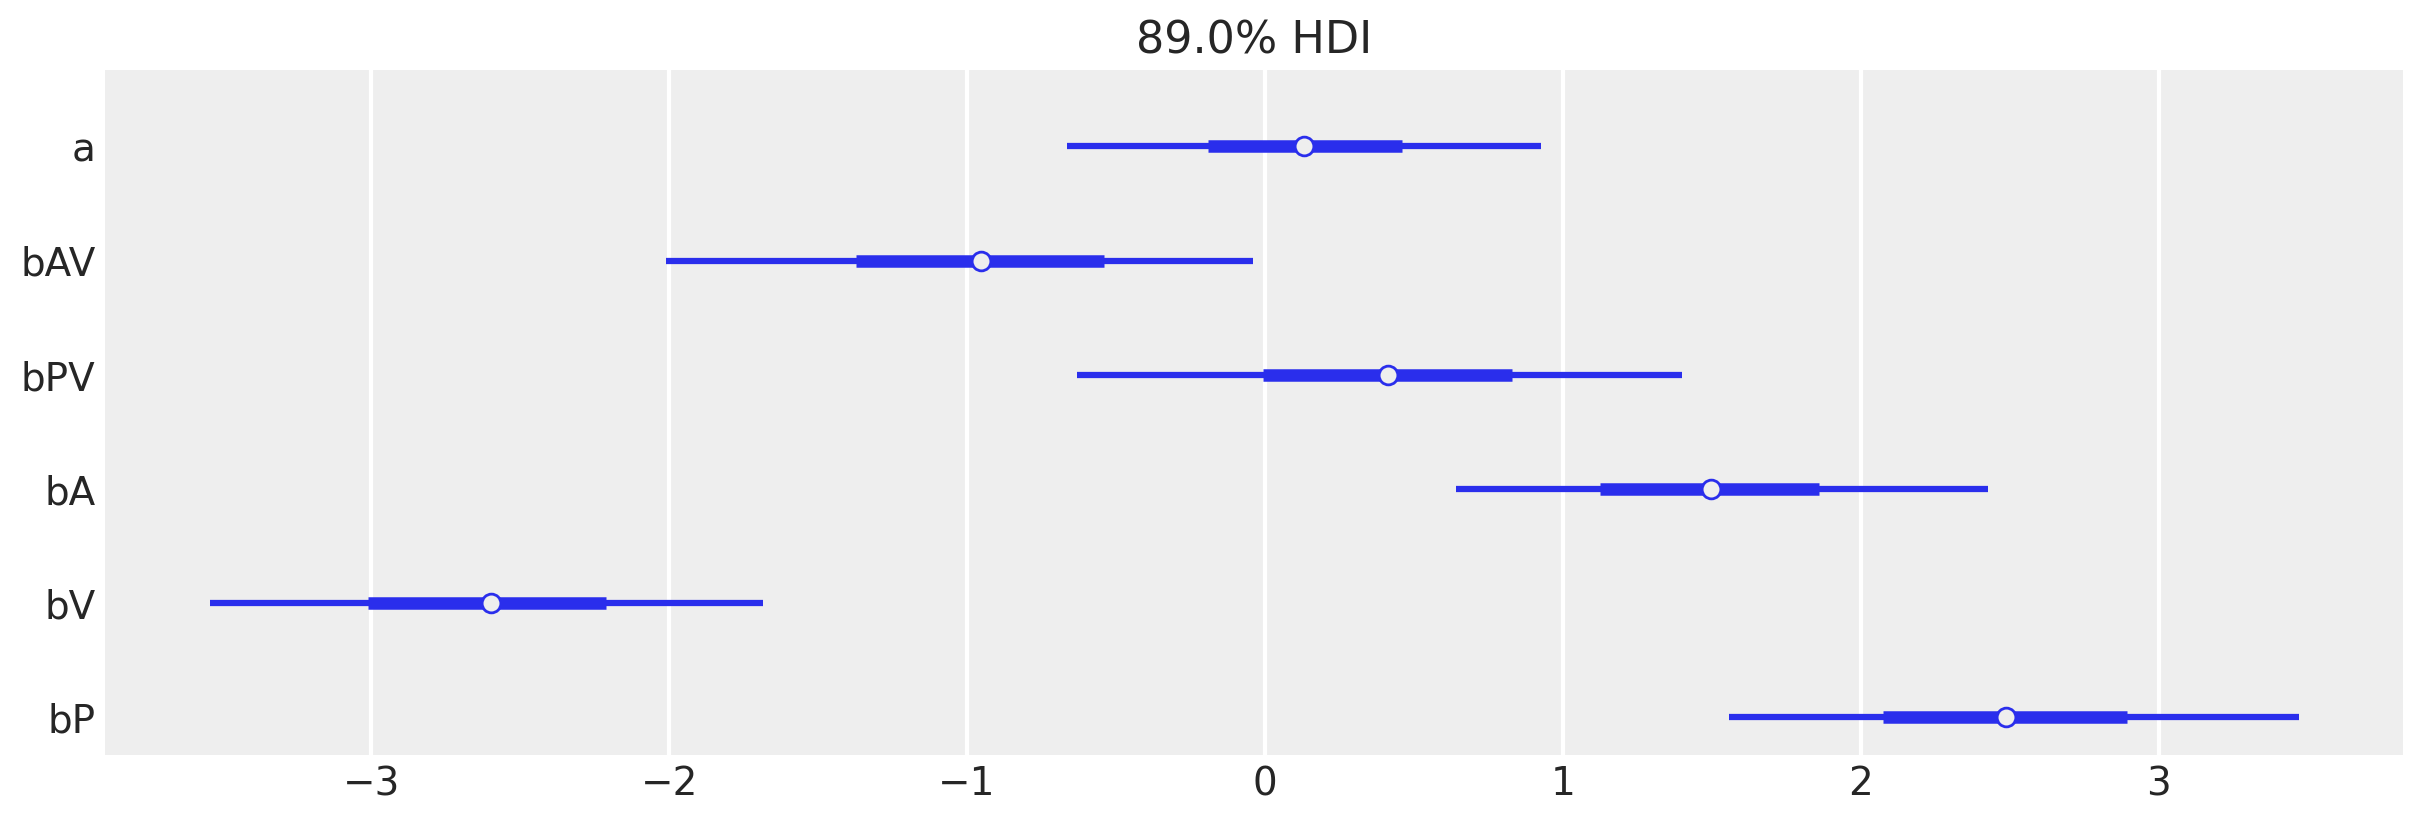

<IPython.core.display.Javascript object>

In [285]:
f, ax1 = plt.subplots(figsize=(12, 4))
az.plot_forest(
    trace_glmE5, var_names=["a", "bAV", "bPV", "bA", "bV", "bP"], combined=True, ax=ax1
)

### Make predictions

In [295]:
with glmE5:
    post_pred = pm.sample_posterior_predictive(
        trace=trace_glmE5, var_names=["p", "catches"], random_seed=55
    )
post_pred

{'p': array([[0.73862371, 0.99236035, 0.68001259, ..., 0.85121971, 0.06489608,
         0.56770326],
        [0.57865477, 0.97842951, 0.49212037, ..., 0.80206532, 0.10872185,
         0.44458844],
        [0.7905414 , 0.98856299, 0.64884944, ..., 0.76199021, 0.08968724,
         0.33476623],
        ...,
        [0.64319667, 0.99295212, 0.66691626, ..., 0.90188583, 0.06909993,
         0.53495106],
        [0.84051803, 0.99406216, 0.61250155, ..., 0.88504185, 0.11644294,
         0.47947576],
        [0.77984385, 0.97366733, 0.46570179, ..., 0.89335737, 0.0661047 ,
         0.55156556]]),
 'catches': array([[20, 28, 19, ..., 15,  3,  4],
        [17, 28,  9, ..., 12,  5,  3],
        [14, 29, 19, ..., 12,  0,  2],
        ...,
        [17, 28, 25, ..., 14,  1,  3],
        [18, 29, 17, ..., 13,  2,  2],
        [19, 28, 12, ..., 14,  2,  2]])}

<IPython.core.display.Javascript object>

In [297]:
post_pred["p"].shape

(4000, 8)

<IPython.core.display.Javascript object>

How do I know which column belongs to which group?

In [351]:
df_eagles

,y,n,P,A,V,P_code,A_code,V_code
0,17,24,L,A,L,1,1,1
1,29,29,L,A,S,1,1,0
2,17,27,L,I,L,1,0,1
3,20,20,L,I,S,1,0,0
4,1,12,S,A,L,0,1,1
5,15,16,S,A,S,0,1,0
6,0,28,S,I,L,0,0,1
7,1,4,S,I,S,0,0,0


<IPython.core.display.Javascript object>

Each of P_code, A_code, and V_code are labeled 0 and 1. You can look at each combination. But what order are they in?

In [315]:
glmE5.catches

catches ~ Binomial

<IPython.core.display.Javascript object>

In [329]:
glmE5.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7f98323d9d00>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'a': a ~ Normal,
  'bP': bP ~ Normal,
  'bV': bV ~ Normal,
  'bA': bA ~ Normal,
  'bPV': bPV ~ Normal,
  'bAV': bAV ~ Normal,
  'p': p ~ Deterministic,
  'catches': catches ~ Binomial},
 'free_RVs': [a ~ Normal,
  bP ~ Normal,
  bV ~ Normal,
  bA ~ Normal,
  bPV ~ Normal,
  bAV ~ Normal],
 'observed_RVs': [catches ~ Binomial],
 'deterministics': [p ~ Deterministic],
 'potentials': [],
 'missing_values': [],
 'a': a ~ Normal,
 'bP': bP ~ Normal,
 'bV': bV ~ Normal,
 'bA': bA ~ Normal,
 'bPV': bPV ~ Normal,
 'bAV': bAV ~ Normal,
 'p': p ~ Deterministic,
 'catches': catches ~ Binomial,
 '_cache': defaultdict(dict,
             {'bijection': {(5740354900026072187,
                5740354900026072187): <pymc3.blocking.DictToArrayBijection at 0x7f988180d0d0>}}

<IPython.core.display.Javascript object>

In [335]:
glmE5.bP

bP ~ Normal

<IPython.core.display.Javascript object>

In [342]:
glmE5.__dict__

{'_parent': None,
 '_theano_config': {'compute_test_value': 'raise'},
 '_config_context': <theano.configparser._ChangeFlagsDecorator at 0x7f98323d9d00>,
 'name': '',
 'coords': {},
 'RV_dims': {},
 'check_bounds': True,
 'named_vars': {'a': a ~ Normal,
  'bP': bP ~ Normal,
  'bV': bV ~ Normal,
  'bA': bA ~ Normal,
  'bPV': bPV ~ Normal,
  'bAV': bAV ~ Normal,
  'p': p ~ Deterministic,
  'catches': catches ~ Binomial},
 'free_RVs': [a ~ Normal,
  bP ~ Normal,
  bV ~ Normal,
  bA ~ Normal,
  bPV ~ Normal,
  bAV ~ Normal],
 'observed_RVs': [catches ~ Binomial],
 'deterministics': [p ~ Deterministic],
 'potentials': [],
 'missing_values': [],
 'a': a ~ Normal,
 'bP': bP ~ Normal,
 'bV': bV ~ Normal,
 'bA': bA ~ Normal,
 'bPV': bPV ~ Normal,
 'bAV': bAV ~ Normal,
 'p': p ~ Deterministic,
 'catches': catches ~ Binomial,
 '_cache': defaultdict(dict,
             {'bijection': {(5740354900026072187,
                5740354900026072187): <pymc3.blocking.DictToArrayBijection at 0x7f988180d0d0>}}

<IPython.core.display.Javascript object>

In [346]:
for name, val in glmE5.__dict__.items():

    if callable(val):
        #   val()
        print(name, val)

_config_context <theano.configparser._ChangeFlagsDecorator object at 0x7f98323d9d00>


<IPython.core.display.Javascript object>

In [348]:
[f for _, f in glmE5.__dict__.items() if callable(f)]

<IPython.core.display.Javascript object>

In [324]:
list(filter(lambda x: "__" in x, dir(glmE5)))

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__latex__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__']

<IPython.core.display.Javascript object>

In [317]:
list(filter(lambda x: "__" not in x, dir(glmE5)))

['RV_dims',
 'Var',
 '_cache',
 '_config_context',
 '_context_class',
 '_parent',
 '_repr_latex_',
 '_str_repr',
 '_theano_config',
 'a',
 'add_coords',
 'add_random_variable',
 'bA',
 'bAV',
 'bP',
 'bPV',
 'bV',
 'basic_RVs',
 'bijection',
 'catches',
 'check_bounds',
 'check_test_point',
 'cont_vars',
 'contexts',
 'coords',
 'd2logp',
 'd2logp_nojac',
 'datalogpt',
 'deterministics',
 'dict_to_array',
 'disc_vars',
 'dlogp',
 'dlogp_array',
 'dlogp_nojac',
 'fastd2logp',
 'fastd2logp_nojac',
 'fastdlogp',
 'fastdlogp_nojac',
 'fastfn',
 'fastlogp',
 'fastlogp_nojac',
 'flatten',
 'fn',
 'free_RVs',
 'isroot',
 'logp',
 'logp_array',
 'logp_dlogp_function',
 'logp_elemwise',
 'logp_nojac',
 'logp_nojact',
 'logpt',
 'makefn',
 'missing_values',
 'model',
 'name',
 'name_for',
 'name_of',
 'named_vars',
 'ndim',
 'observed_RVs',
 'p',
 'parent',
 'potentials',
 'prefix',
 'profile',
 'root',
 'shape_from_dims',
 'test_point',
 'unobserved_RVs',
 'varlogpt',
 'vars']

<IPython.core.display.Javascript object>

In [318]:
glmE5.p

p ~ Deterministic

<IPython.core.display.Javascript object>

In [319]:
glmE5.basic_RVs

[a ~ Normal,
 bP ~ Normal,
 bV ~ Normal,
 bA ~ Normal,
 bPV ~ Normal,
 bAV ~ Normal,
 catches ~ Binomial]

<IPython.core.display.Javascript object>

In [323]:
for (
    name,
    val,
) in glmE5.__module__:  # iterate through every module's attributes
    if callable(val):  # check if callable (normally functions)
        val()  # call it

ValueError: not enough values to unpack (expected 2, got 1)

<IPython.core.display.Javascript object>

## Assumption, 0 and 1 in alphabetical order - or in order of the data?

In [350]:
var_list = ['A', 'P', 'V']
nums = ['0','1']

for var in var_list:
    for num in nums:
        print(var + num)


A0
A1
P0
P1
V0
V1


<IPython.core.display.Javascript object>

### Just try plotting and see ... the order is encoded when building the model

Both `n` and `observed` put in the order implicitly.

```
catches = pm.Binomial("catches", p=p, n=df_eagles["n"], observed=df_eagles["y"]
```

In [353]:
df_eagles["prop_obs"] = df_eagles["y"] / df_eagles["n"]

,y,n,P,A,V,P_code,A_code,V_code,prop_obs
0,17,24,L,A,L,1,1,1,0.708333
1,29,29,L,A,S,1,1,0,1.000000
2,17,27,L,I,L,1,0,1,0.629630
3,20,20,L,I,S,1,0,0,1.000000
4,1,12,S,A,L,0,1,1,0.083333
5,15,16,S,A,S,0,1,0,0.937500
6,0,28,S,I,L,0,0,1,0.000000
7,1,4,S,I,S,0,0,0,0.250000


<IPython.core.display.Javascript object>

In [359]:
# predictions
pred_mean = post_pred["p"].mean(axis=0)
df_eagles["prop_pred"] = pred_mean

<IPython.core.display.Javascript object>

In [368]:
df_eagles[["lower_b", "upper_b"]] = az.hdi(post_pred["p"])

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/stats/stats.py:493: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


<IPython.core.display.Javascript object>

In [379]:
df_eagles

,y,n,P,A,V,P_code,A_code,V_code,prop_obs,prop_pred,lower_b,upper_b
0,17,24,L,A,L,1,1,1,0.708333,0.719807,0.592875,0.846169
1,29,29,L,A,S,1,1,0,1.000000,0.980485,0.963419,0.997294
2,17,27,L,I,L,1,0,1,0.629630,0.604916,0.474857,0.739129
3,20,20,L,I,S,1,0,0,1.000000,0.923357,0.865116,0.981337
4,1,12,S,A,L,0,1,1,0.083333,0.138587,0.044132,0.230394
5,15,16,S,A,S,0,1,0,0.937500,0.825161,0.717592,0.935543
6,0,28,S,I,L,0,0,1,0.000000,0.085417,0.026170,0.139285
7,1,4,S,I,S,0,0,0,0.250000,0.533154,0.340693,0.717138


<IPython.core.display.Javascript object>

In [392]:
xticklabels = (df_eagles["P"] + df_eagles["A"] + df_eagles["V"]).tolist()
xticklabels

['LAL', 'LAS', 'LIL', 'LIS', 'SAL', 'SAS', 'SIL', 'SIS']

<IPython.core.display.Javascript object>

Text(0, 0.5, 'proportion observed and predicted')

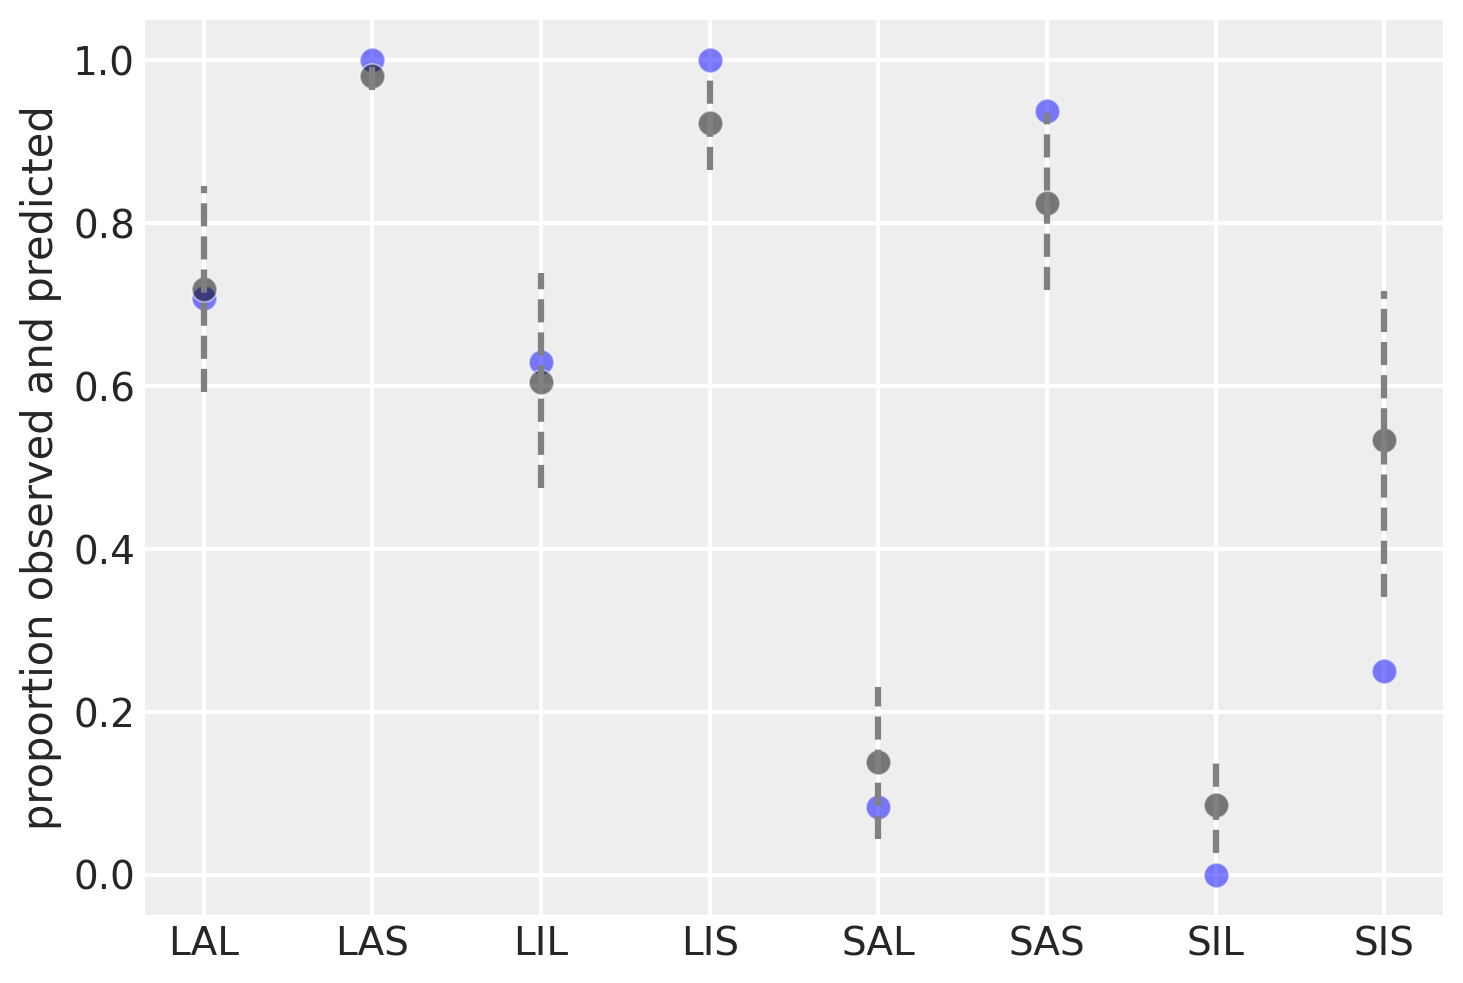

<IPython.core.display.Javascript object>

In [397]:
f, ax1 = plt.subplots()

sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_obs",
    ax=ax1,
    color="blue",
    alpha=0.5,
)

sns.scatterplot(
    data=df_eagles,
    x=range(len(df_eagles)),
    y="prop_pred",
    ax=ax1,
    color="black",
    alpha=0.5,
)

ax1.vlines(
    x=range(len(df_eagles)),
    ymin=df_eagles["lower_b"],
    ymax=df_eagles["upper_b"],
    color="gray",
    linestyle="dashed",
)

# Rename xticklabels
ax1.set_xticks(range(0, 8))  # Necessary to set proper positions
ax1.set_xticklabels(xticklabels)

ax1.set_ylabel("proportion observed and predicted")

In [ ]:
# 

Appendix: Environment and system parameters

In [3]:
%watermark -n -u -v -iv -w

Last updated: Wed May 26 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

scipy     : 1.6.0
pandas    : 1.2.1
arviz     : 0.11.1
json      : 2.0.9
matplotlib: 3.3.4
pymc3     : 3.11.0
seaborn   : 0.11.1
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>